In [1]:
##
#     Libraries
####

import pandas as pd
import numpy as np
import os
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from matplotlib.pyplot import cm
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import spatial
import numpy.matlib
import gc
import copy


from outliers import smirnov_grubbs as grubbs

pd.__version__

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))

'0.25.3'

In [2]:
#read the brain section features file which is identified by mouseID, day, treatment, celltype, sectionID
#return a pd.dataframe containing a section's main features
def read_mouse_features_file(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    d = pd.read_csv(f,delimiter=delim)
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    for key, info in zip(keyList,infoList):
        d[key] = [info]*len(d)
        
    return d
    
def read_mouse_features(path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",
                        id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]):
    mice = []
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list) or (celltype_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list,celltype_list=celltype_list)
        print(files)
    if filetype == "fractal":
        print("--- reading factal files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_fractals2(f,path=path,delim=delim,boxsize=boxsize,scale=scale,threshold=threshold))
    elif filetype == "features":
        print("--- reading features files ---")
        for f in files:
            print(f)
            mice.append(read_mouse_features_file(f,path=path,delim=delim,boxsize=boxsize,scale=scale,threshold=threshold))
    allMice = pd.concat(mice,ignore_index=True)
    return allMice

def read_mouse_fractals(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    #fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals

def read_mouse_fractals2(file,path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',windows=False):
    sep=""
    if windows:
        if not (path[:-1] == "\\"):
            path += "\\"
    else:
        if not (path[:-1] == "/"):
            path += "/"
            
    f = f"{path}{sep}{file}"
    ms, day, cond, cell, sect, start = file.split("_")
    keyList = ["ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']
    infoList = [ms,day,cond,sect,cell,boxsize,scale,threshold]
    
    d = pd.read_csv(f,delimiter=delim)
    fractals = d.loc[d["D"]>0,["BX","BY","D"]]
    fractals.loc[:,["BX","BY"]] = d[["BX","BY"]].iloc[fractals.index - 1].values
    for key, info in zip(keyList,infoList):
        fractals.loc[:,key] = [info]*len(fractals)
    return fractals
     
def check_file_list(files,id_list=[],sec_list=[],day_list=[],treatment_list=[],celltype_list=[]):
    newFiles = []
    for f in files:
        include=True
        if len(f.split("_")) > 5:
            ms, day, cond, cell, sec, xtra = f.split("_")
        else:
            ms, day, cond, cell, sec = f.split("_")
            sec = sec[:-4]

        if day_list:
            include = include and (day in day_list)
        if id_list:
            print(ms,": ,",(ms in id_list))
            include = include and (ms in id_list) #(ms.upper() in map(lambda x:x.lower(),id_list))
        if treatment_list:
            include = include and (cond in treatment_list)
        if sec_list:
            print(sec,": ,",(sec in sec_list))
            print(sec_list)
            include = include and (sec in sec_list)
        if celltype_list:
            print(f"cell: {cell in celltype_list}")
            include = include and (cell in celltype_list)
        if include:
            newFiles.append(f)
        print(f,": ",f.split("_"),": ",include)
    return newFiles
    
def merge_feature_files(DF1,DF2, on =["BX","BY","ID","Day","Treatment","Section","CellType",'Boxsize','Threshold'],how="outer"):
    return pd.merge(DF1,DF2,on=on,how=how)

##
# 
# Iter through all sections as grouped by cell type and ID
#s if splitByTreatment: 
#        return a list of [untreated, treated] sections, order is not preserved, treatment determined by treatmentCol
#######
def iter_mice_sections(mice,cell="microglia",splitByTreatment=True,treatmentCol="Treatment",control="noFUS",treatment="FUS"):
    IDs = np.unique(mice.loc[mice["CellType"]==cell,["ID"]])
    for ID in IDs:
        secs = np.unique(mice.loc[( (mice["ID"]==ID) & (mice["CellType"]==cell) ),["Section"]])
        for s in secs:
            sec = mice.loc[( (mice["ID"] == ID) & (mice["Section"] == s) & (mice["CellType"] == cell) )]
            if splitByTreatment:
                sec = split_column(sec,col=treatmentCol,control=control,treatment=treatment)
            yield sec
            
def iter_mice_sections2(mice,cell="microglia",control="noFUS",treatment="FUS",treatmentCol="Treatment",splitByTreatment=True):
    mice = mice.set_index(["CellType","ID","Section","Treatment",'Boxsize','Threshold',"boxID"])
    x = mice.xs(cell,level="CellType",drop_level=False)
    for index, df in x.groupby(level=["ID","Section"]):
        print(index)
        treatments = df.index.get_level_values(treatmentCol)
        if ((control in treatments) and (treatment in treatments)):
            result = df.reset_index()
            if splitByTreatment:
                con = df.xs(control,level="Treatment",drop_level=False)
                trt = df.xs(treatment,level="Treatment",drop_level=False)
                result = [con.reset_index(), trt.reset_index()]
            yield result
        else:
            print('ITER PROBLEM')
        
        
def set_box_id(mice):
    mice.loc[:,"boxID"] = np.arange(0,len(mice))
    return mice

#returns a list of dataframes split from a larger dataframe over the values of a defined column
def split_column(df,col="Treatment",control="noFUS",treatment="FUS"):
    return df.loc[df[col]==control], df.loc[df[col]==treatment]

def round_digits(df,features=['BX','BY']):
    df.loc[:,features] = df[features].astype('float').round(1)
    return df


print('done')

done


In [165]:
import decimal
import itertools
decimal.getcontext().rounding = decimal.ROUND_DOWN


def add_grid_thresholds(to_add,mice,col='Threshold'):
    re=[]
    thresholds = mice[col].unique()
    for t in thresholds:
        _ = copy.copy(to_add)
        _.loc[:,col]=t
        re.append(_)
    return pd.concat(re)

def add_all_cell_data2(mice,boxsize=150,
                       path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\output_whole\\microglia\\cell_counts\\counts\\",
                      nnd=True, id_list=[], day_list=[], treatment_list=[],sec_list=[], centers=['X','Y'], fill_nan=True, slide=2,
                      ):
    begin=time.time()
    files = os.listdir(path)
    if (id_list) or (day_list) or (treatment_list) or (sec_list):
        files = check_file_list(files,id_list=id_list,day_list=day_list,treatment_list=treatment_list,sec_list=sec_list)
        print(files)
    keys = ["ID","Day","Treatment","Section","CellType",'Boxsize']
    to_add = []
    for f in files:
        print(f)
        st = time.time()
        ms, day, cond, cell, sect = f.split("_")
        sec = pd.read_csv(path+f,"\t")
        sec = sec.rename(columns={" " : "cellID"})
        
        for k,t in zip(keys,[ms,day,cond,sect[:-4],cell,boxsize]):
            sec.loc[:,k] = t
        if nnd:
            nnd_df = construct_nnd_df(sec, xy=centers)
            sec = pd.merge(sec, nnd_df, on=centers)
            
            to_add.append(sec)
            
            
    to_add = pd.concat(to_add,ignore_index=True)
    to_add = add_grid_thresholds(to_add,mice) #add thresholds from mice to to_add(i.e. single_threshold / paired threshold)
    
    mice = add_cell_data3(mice,to_add)
    #mice = add_cell_data2(mice,to_add,boxsize=boxsize, centers=centers, slide=slide)
    
    mice.loc[:,'ave_nnd'] = mice['sum_cell_nnd'] / mice['cell_counts']
    mice.loc[:,'ave_soma_size'] = mice['sum_cell_area'] / mice['cell_counts']
    mice.loc[:,'ave_soma_circularity'] = (4* np.pi * mice['sum_cell_area']) / (mice['sum_cell_perim_squared']) #4Ï€â€…Ã—â€…[Area] / [Perimeter]**2
    
    if fill_nan:
        fill = {}
        for c in ['ave_nnd','ave_soma_size','ave_soma_circularity','cell_counts']:
            fill[c] = 0
        mice.fillna(fill, inplace=True)
    
    print('total_time: ', time.time()-begin)
    return mice
       
def get_first_cat(x):
    return x.left

def align_cellfeats_index(cells,index_names,index,xy=['BX','BY'],decimals=3):
    for k, v in zip(index_names,index):
        cells.loc[:,k] = v
    #cells.loc[:,xy] = cells[xy],d
    return cells.set_index(index_names+xy)

  
    
def get_ranges2(rangeinindex,xy,slide=2,slide_size=100):
    range_ = np.unique(rangeinindex.index.get_level_values(xy))
    ranges = []
    for i in range(0,slide):
        _ = np.arange(i,len(range_),slide)
        #for cut need to add one more upper boundary so the previous upper boundary is considered
        last = range_[_[-1]]
        grid = range_[_]
        
        '''
        if last % slide_size == 0: #add 0 as a lower bound into the correct range (i.e. the one defined by window_size * n)
            grid = np.append(np.array[0],grid)
        '''
        grid = np.append(grid,[last+slide_size])
        ranges.append(grid)
        
    return ranges
'''
input pandas series
Corrects a weird error with pd.cut which subtracts lower bound by 10**-decimal from only the first category
returns pandas series with 10**-decimal added back to first category.
'''
def correct_cut_error(listofarrays,listofxy=[],decimals=3):
    if listofxy:
        for ar, xy in zip(listofarrays,listofxy):
            minxy = np.nanmin(xy) - 10**(decimals*-1)
            if minxy in ar.values:
                ar = cut_correction(ar,decimals=decimals)
            yield ar
    else:
        for ar in listofarrays:
            yield cut_correction(ar,decimals=decimals)
            
def cut_correction(ar,decimals=3):
    _ = np.nanmin(ar.values)
    ar = pd.to_numeric(ar)
    ar.loc[ar==_] = ar.loc[ar==_] + 10**(decimals*-1)
    return ar

def correct_cut_error2(listofarrays,decimals=1):
    corrected = []
    for arr in listofarrays:
        corrected.append(arr.apply(lambda x: round(x, decimals)))
    return corrected

def add_cell_data3(main, cells, indeces=['CellType','ID','Day','Treatment','Section','Boxsize','Threshold'],xy=['BX','BY'],cell_centers=['X','Y'],boxsize=150,scale=1.5,slide=2,decimals=1,skipfirstlines=2):
    counting_frames = []
    cells.loc[:,'perim_squared']=cells['Perim.']**2
    to_add = cells[indeces+cell_centers+['Area','Perim.','perim_squared','cellID','nnd']]
    square_length = boxsize / scale / slide
    for i in range(0,slide):
        to_add.loc[:,'grid_cat_x'] = (to_add[cell_centers[0]] / square_length).apply(int) - i
        to_add.loc[:,'grid_cat_y'] = (to_add[cell_centers[1]] / square_length).apply(int) - i #caution, could be -1
        
    to_add.loc[:,'BX'] = round(to_add['grid_cat_x'] * square_length)
    to_add.loc[:,'BY'] = round(to_add['grid_cat_y'] * square_length)
    
    to_add = to_add.loc[(to_add['BX']>0) & (to_add['BY']>0)] #prevents previous operation from allowing the grid to spand negative numbers
    
    
    main = main.set_index(indeces+xy)
    to_add = to_add.groupby(indeces+xy)[['cellID','Area','perim_squared','nnd']].agg({'cellID':'count',
                                                                             'Area': 'sum',
                                                                             'perim_squared': 'sum',
                                                                             'nnd': 'sum'})
    to_add = to_add.rename(columns = {'cellID' : 'cell_counts',
                                      'Area':'sum_cell_area', 
                                      'perim_squared' : 'sum_cell_perim_squared',
                                      'nnd': 'sum_cell_nnd'})
    
    for col in to_add.columns.values:
        st = time.time()
        main.loc[to_add.index,col] = to_add[col]
        print('time per col: ', time.time()-st)
    return main.reset_index()
    
        
    #print(to_add[['X','grid_cat_x','BX2','Y','grid_cat_y','BY2']])
    

def add_cell_data2(main,add,nnd=True,indeces=['CellType','ID','Day','Treatment','Section','Boxsize','Threshold'],xy=['BX','BY'],centers=['X','Y'],boxsize=150,scale=1.5,overlapping_grid=True,slide=2,decimals=1,skipfirstlines=2):
    print('main length',len(main))
    main.loc[:,xy] = np.round(main[xy],decimals=decimals)
    main = main.set_index(indeces+xy) # mice DF categorized into boxes
    
    add.loc[:,'perim_squared'] = add['Perim.']**2
    add = add.set_index(indeces)[centers+['Area','Perim.','perim_squared','cellID','nnd']] #cells to add
    #main = main.sort_values(by=['Area'],ascending=False)
    #boxsize = boxsize/scale
    toadd = []
    
    # iter through cell box indexes...
    for indexes, df in add.groupby(level=indeces):
        
        print(f" processing section: {indexes}")
        ranges = main.xs(indexes,level=tuple(indeces)).sort_values(by=['Area'],ascending=False) # get the corresponding box indeces in the main mouse, sort by area to remove the background DFs
        ranges = ranges.iloc[skipfirstlines:] #remove the background areas
        
        #one cell can be in multiple overlapping grids... therefore need to iter through grid ranges
        if overlapping_grid:
            xs = get_ranges2(ranges,xy[0],slide=slide)
            ys = get_ranges2(ranges,xy[1],slide=slide)
            
            # bin the data into equally spaced groups
            cut_x = []
            cut_y = []
            
            for x in xs:
                cut_x.append(pd.cut(df[centers[0]], x, include_lowest=True, retbins=False).apply(get_first_cat))
                
            for y in ys:
                cut_y.append(pd.cut(df[centers[1]], y, include_lowest=True, retbins=False).apply(get_first_cat))
            cut_x = correct_cut_error2(cut_x)
            cut_y = correct_cut_error2(cut_y)
            
            print(cut_x, cut_y)
            stop
            
            DFs = []
            #for x,y in zip([x1,x1,x2,x2],[y1,y2,y1,y2]):
            for x,y in list(itertools.product(cut_x, cut_y)):
                
                print(x)
                print(y)
                
                stop
                _ = df.groupby([x, y])[['cellID','Area','perim_squared','nnd']].agg({'cellID':'count',
                                                                             'Area': 'sum',
                                                                             'perim_squared': 'sum',
                                                                             'nnd': 'sum'})
                DFs.append(_.reset_index())
            grouped_cells = pd.concat(DFs)
            grouped_cells = grouped_cells.rename(columns = {centers[0] : xy[0], 
                                                            centers[1] : xy[1], 
                                                            'cellID' : 'cell_counts',
                                                            'Area':'sum_cell_area', 
                                                            'perim_squared' : 'sum_cell_perim_squared',
                                                           'nnd': 'sum_cell_nnd'})
            
            grouped_cells = align_cellfeats_index(grouped_cells,indeces,indexes)
            toadd.append(grouped_cells)
    #'''
    toadd = pd.concat(toadd)
    print("done")
    #'''
    for ID in ['JS12','JS13','JS14','JS16']:
        
        for ix in range(5,10):
            print(toadd.index[ix])
            x = toadd.index[ix][7]
            y = toadd.index[ix][8]
            print(x,y)
            print(main.loc[(main.index.get_level_values('BX') == x) & (main.index.get_level_values('BY') == y)])
            print(main.loc[toadd.index[ix],])
            print("==================================")

            #
        stop
        
        #print(ID)
        #_ = toadd.xs(ID, level='ID', drop_level=False)
        #test2 = _.index[2]
        #self_test = main.index[2]
        
        #for v in toadd.index:
        '''
        for i in range(0,10):
            print(toadd.index.get_level_values(i).dtype)
            print(main.index.get_level_values(i).dtype)
        '''
            
        #for v in main.index:
        #print(main.index.get_level_values(v).dtype)
        
        
        print(main.loc[self_test,:])
        print("==========")
        print(main.loc[test2,:])
        stop
        for col in toadd.columns.values:
            st = time.time()
            main.loc[_.index,col] = toadd[col]
            print('time per col: ', time.time()-st)
    #'''
    for col in toadd.columns.values:
        st = time.time()
        main.loc[toadd.index,col] = toadd[col]
        print('time per col: ', time.time()-st)
        #stop
    #'''
    print(main.columns.values)
    print('post merge main length',len(main))
    print(time.time()-st)
    return main.reset_index()

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index
    
def get_nnd(xy):
    dist, ind = do_kdtree(xy,xy)
    point1=xy
    point2=xy[ind[:,1]]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])

print('done')

done


In [11]:
def compile_feature_df(base_path = f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/",
                       feature_extension = "/feature_files/",
                       count_extension = "/count_data/counts/",
                       count_data = False,
                       _slide=2,
                       set_ = "set1",
                       boxsizes = [150],
                       thresholds = ['single_threshold'],
                       IDs = ['JS12','JS13','JS14','JS16', 'JS83', 'JS84', 'JS85', 'JS89', 'JS90'],
                       celltypes=['gfap'],
                       sections=[]
                      ):
    feature_dfs = []
    branch_feature_dfs = []
    fractal_dfs = []
    
    for t in thresholds:
        for b in boxsizes:
            full_feat_path = f"{base_path}/{set_}/{feature_extension}/{t}/features/{b}/"
            full_fractal_path = f"{base_path}/{set_}/{feature_extension}/{t}/fractal_dimension/datafiles/{b}/"
            full_branch_path = f"{base_path}/{set_}/{feature_extension}/{t}/branch_features/{b}/"
            feature_dfs.append(read_mouse_features(path=full_feat_path,boxsize=b,threshold=t,filetype='features',treatment_list=[],id_list=IDs,celltype_list=celltypes,sec_list=sections)) #path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]
            branch_feature_dfs.append(read_mouse_features(path=full_branch_path,boxsize=b,threshold=t,filetype='features',treatment_list=[],id_list=IDs,celltype_list=celltypes,sec_list=sections)) #path="",delim="\t",boxsize=150,scale=1.5,threshold='paired_threshold',filetype="features",id_list=[],day_list=[],treatment_list=[],sec_list=[],celltype_list=[]
            fractal_dfs.append(read_mouse_features(path=full_fractal_path,boxsize=b,threshold=t,filetype='fractal',treatment_list=[],id_list=IDs,celltype_list=celltypes,sec_list=sections))

    feat_df = round_digits(pd.concat(feature_dfs))
    fract_df = round_digits(pd.concat(fractal_dfs))
    branch_df = round_digits(pd.concat(branch_feature_dfs))

    '''
    print(feat_df.columns.values)
    print(fract_df.columns.values)
    print(branch_df.columns.values)
    '''

    #'''
    df = merge_feature_files(feat_df, fract_df,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
    df = merge_feature_files(df, branch_df, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
    #'''
    
    if count_data:
        for t in thresholds:
            for boxsize in [150]:
                cell_count_path = f"{base_path}/{set_}/{feature_extension}/{t}/{count_extension}/"
                print(cell_count_path)
                df = add_all_cell_data2(df,boxsize=boxsize,id_list=IDs,nnd=True,slide=_slide,
                                        path=cell_count_path)
        gc.collect()

    #'''
    
    return df
    #untr_df_gfap = df_gfap.loc[(df_gfap['Day']=='untreated')]
    #trt_df_gfap = df_gfap.loc[(df_gfap['Day'] == "7D")]

In [151]:
####
#    iba1 lectin ter119 dataset
################################

import gc
import copy


#'''
features = []
fractals = []
branches = []

_dir = 'E'


_set = 'set1'
_slide = 2


id_list = ['JS1','JS2','JS3','JS64']

#'''
for t in ['single_threshold']:
    for boxsize in [150]:
        feature_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setErythro_19-8-28/output/{_set}/feature_files/{t}/features/{boxsize}"
        fractal_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setErythro_19-8-28/output/{_set}/feature_files/{t}/fractal_dimension/datafiles/{boxsize}/"
        branch_path = f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setErythro_19-8-28/output/{_set}/feature_files/{t}/branch_features/{boxsize}/"
        
        features.append(read_mouse_features(path=feature_path,filetype='features',boxsize=boxsize,threshold=t,id_list=id_list, celltype_list=['iba1']))
        fractals.append(read_mouse_features(path=fractal_path,filetype='fractal',boxsize=boxsize,threshold=t,id_list=id_list, celltype_list=['iba1']))
        branches.append(read_mouse_features(path=branch_path,boxsize=boxsize,threshold=t,filetype='features',treatment_list=[],id_list=id_list,celltype_list=['iba1'],sec_list=[]))
        
features = round_digits(pd.concat(features))
fractals = round_digits(pd.concat(fractals))
branches = round_digits(pd.concat(branches))

print(features[["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']])
print(fractals[["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold']])
        
mice_7d = merge_feature_files(features,fractals,on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])
mice_7d = merge_feature_files(mice_7d, branches, on=["BX","BY","ID","Day","Treatment","Section","CellType","Boxsize","Scale",'Threshold'])

for boxsize in [150]:
    mice_7d = add_all_cell_data2(mice_7d,boxsize=boxsize,id_list=id_list,nnd=True,slide=_slide,
                       path=f"{_dir}:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setErythro_19-8-28/output/{_set}/feature_files/single_threshold/count_data/counts/")
    gc.collect()

print('done')

JS1 : , True
cell: True
JS1_1D_FUS_iba1_sec2_150X150.txt :  ['JS1', '1D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS1 : , True
cell: True
JS1_1D_FUS_iba1_sec4_150X150.txt :  ['JS1', '1D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS2 : , True
cell: True
JS2_1D_FUS_iba1_sec2_150X150.txt :  ['JS2', '1D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS3 : , True
cell: True
JS3_1D_FUS_iba1_sec2_150X150.txt :  ['JS3', '1D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS64 : , True
cell: True
JS64_1D_FUS_iba1_sec4_150X150.txt :  ['JS64', '1D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS3 : , True
cell: True
JS3_1D_FUS_iba1_sec4_150X150.txt :  ['JS3', '1D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS1 : , True
cell: True
JS1_1D_FUS_iba1_sec6_150X150.txt :  ['JS1', '1D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS2 : , True
cell: True
JS2_1D_FUS_iba1_sec4_150X150.txt :  ['JS2', '1D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS64 : , True
cell: True
JS64_1D_FUS_

KeyboardInterrupt: 

In [307]:
'''
abcam_iba1_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/abcam_iba1/output/",
                       set_ = "set1",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'],
                                   count_data=True,
                                   celltypes=['iba1'])

abcam_iba1_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/",
                       set_ = "set1",
                       IDs = ['JS12', 'JS13', 'JS14', 'JS16'],
                                   count_data=True,
                                   celltypes=['iba1'])
'''

'''
wako_iba1_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/wako_iba1/output/",
                       set_ = "set1",
                                    celltypes=['iba1'],
                                    count_data=True,
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'])
'''

'''
wako_iba1_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/",
                       set_ = "Iba1_set2",
                                   celltypes=['microglia'],
                                    count_data=True,
                       IDs = ['JS12','JS13','JS14','JS16'])
wako_iba1_trt.loc[:,'CellType'] = 'iba1'
'''



'''
wako_iba1_trt2 = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/",
                       set_ = "set1",
                                   celltypes=['iba1'],
                                    count_data=True,
                       IDs = ['JS12','JS13','JS14','JS16'])

'''

wako_iba1_trt2 = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/",
                       set_ = "set1",
                                   celltypes=['iba1'],
                                    count_data=True,
                       IDs = ['JS12','JS13','JS14','JS16'])

JS16 : , True
cell: True
JS16_7D_noFUS_iba1_sec6_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_noFUS_iba1_sec4_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_noFUS_iba1_sec2_150X150.txt :  ['JS16', '7D', 'noFUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec6_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec2_150X150.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS14 : , True
cell: True
JS14_7D_FUS_iba1_sec8_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec8', '150X150.txt'] :  True
JS14 : , True
cell: True
JS14_7D_FUS_iba1_sec6_150X150.txt :  ['JS14', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS14

JS16_7D_noFUS_iba1_sec6_0-75.txt
JS16_7D_noFUS_iba1_sec6_75-0.txt
JS16_7D_noFUS_iba1_sec6_75-75.txt
JS16_7D_noFUS_iba1_sec4_0-0.txt
JS16_7D_noFUS_iba1_sec4_0-75.txt
JS16_7D_noFUS_iba1_sec4_75-0.txt
JS16_7D_noFUS_iba1_sec4_75-75.txt
JS16_7D_noFUS_iba1_sec2_0-0.txt
JS16_7D_noFUS_iba1_sec2_0-75.txt
JS16_7D_noFUS_iba1_sec2_75-0.txt
JS16_7D_noFUS_iba1_sec2_75-75.txt
JS16_7D_FUS_iba1_sec6_0-0.txt
JS16_7D_FUS_iba1_sec6_0-75.txt
JS16_7D_FUS_iba1_sec6_75-0.txt
JS16_7D_FUS_iba1_sec6_75-75.txt
JS16_7D_FUS_iba1_sec4_0-0.txt
JS16_7D_FUS_iba1_sec4_0-75.txt
JS16_7D_FUS_iba1_sec4_75-0.txt
JS16_7D_FUS_iba1_sec4_75-75.txt
JS16_7D_FUS_iba1_sec2_0-0.txt
JS16_7D_FUS_iba1_sec2_0-75.txt
JS16_7D_FUS_iba1_sec2_75-0.txt
JS16_7D_FUS_iba1_sec2_75-75.txt
JS14_7D_FUS_iba1_sec8_0-0.txt
JS14_7D_FUS_iba1_sec8_0-75.txt
JS14_7D_FUS_iba1_sec8_75-0.txt
JS14_7D_FUS_iba1_sec8_75-75.txt
JS14_7D_FUS_iba1_sec6_0-0.txt
JS14_7D_FUS_iba1_sec6_0-75.txt
JS14_7D_FUS_iba1_sec6_75-0.txt
JS14_7D_FUS_iba1_sec6_75-75.txt
JS14_7D_FUS_iba1

JS12_7D_noFUS_iba1_sec4_75-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec4', '75-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_0-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec6', '0-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_0-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec6', '0-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_75-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec6', '75-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_75-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec6', '75-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec8_0-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec8', '0-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec8_0-75.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec8', '0-75.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec8_75-0.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec8', '75-0.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec8_75-75.tx

JS14_7D_FUS_iba1_sec4_0-75.txt
JS14_7D_FUS_iba1_sec4_75-0.txt
JS14_7D_FUS_iba1_sec4_75-75.txt
JS14_7D_FUS_iba1_sec2_0-0.txt
JS14_7D_FUS_iba1_sec2_0-75.txt
JS14_7D_FUS_iba1_sec2_75-0.txt
JS14_7D_FUS_iba1_sec2_75-75.txt
JS13_7D_noFUS_iba1_sec6_0-0.txt
JS13_7D_noFUS_iba1_sec6_0-75.txt
JS13_7D_noFUS_iba1_sec6_75-0.txt
JS13_7D_noFUS_iba1_sec6_75-75.txt
JS13_7D_noFUS_iba1_sec4_0-0.txt
JS13_7D_noFUS_iba1_sec4_0-75.txt
JS13_7D_noFUS_iba1_sec4_75-0.txt
JS13_7D_noFUS_iba1_sec4_75-75.txt
JS13_7D_noFUS_iba1_sec2_0-0.txt
JS13_7D_noFUS_iba1_sec2_0-75.txt
JS13_7D_noFUS_iba1_sec2_75-0.txt
JS13_7D_noFUS_iba1_sec2_75-75.txt
JS13_7D_FUS_iba1_sec8_0-0.txt
JS13_7D_FUS_iba1_sec8_0-75.txt
JS13_7D_FUS_iba1_sec8_75-0.txt
JS13_7D_FUS_iba1_sec8_75-75.txt
JS13_7D_FUS_iba1_sec6_0-0.txt
JS13_7D_FUS_iba1_sec6_0-75.txt
JS13_7D_FUS_iba1_sec6_75-0.txt
JS13_7D_FUS_iba1_sec6_75-75.txt
JS13_7D_FUS_iba1_sec4_0-0.txt
JS13_7D_FUS_iba1_sec4_0-75.txt
JS13_7D_FUS_iba1_sec4_75-0.txt
JS13_7D_FUS_iba1_sec4_75-75.txt
JS13_7D_FUS_ib

In [ ]:
####
#    LOAD 7D ITER BOXES -- GFAP NESTIN EXPERIMENT
################################

#'''


'''
novus_gfap_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/",
                       set_ = "gfap_set_final",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'])
                       
novus_gfap_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/",
                       set_ = "gfap_set_final",
                       IDs = ['JS12v3','JS13v3','JS14v3','JS16v3'])
'''
#'''
sc_gfap_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/santacruz_gfap/output/",
                       set_ = "set1",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'])

sc_gfap_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/",
                       set_ = "set1",
                       IDs = ['JS12','JS13','JS14','JS16'])
#'''


In [ ]:
#quick diagnostic of sections:

for index, df in untr_df_gfap.groupby(['ID','Section']):
    con = df.loc[df['Treatment'] == 'L']
    trt = df.loc[df['Treatment'] == 'R']
    
    
    con_mean, con_std = [np.mean(con['IntDen'].dropna().values), np.std(con['IntDen'].dropna().values)]
    trt_mean, trt_std = [np.mean(trt['IntDen'].dropna().values), np.std(trt['IntDen'].dropna().values)]
    print(index)
    
    print(con_mean,con_std,len(con))
    print(trt_mean,trt_std,len(trt))
    

In [249]:
def subtract_section_background(sec,cut=True,background_correct=True):
    '''
    #sec.loc[:,"analyze"] = [0]*len(sec)
    sec = sec.sort_values(by="Area",ascending=False)
    #print(sec[["Area","Mean"]])
    bg_row = sec.iloc[0]
    bg = bg_row["Mean"]
    #rm = data.iloc[2:]  #remove the background means.
    '''
    bg_row = sec.loc[sec['ground']=='background']
    bg = bg_row["Mean"].values[0]
    sec = sec.loc[~(sec['ground']=='background') & ~(sec['ground']=='foreground')]
    
    
    #print(f'background value: {bg}')
    #print(f"length of sec {len(sec)}")
    rmindex = sec.loc[sec["Mean"]>=bg].index
    sec.loc[rmindex,"analyze"] = [1]*len(rmindex)
    sec.loc[:,"analyze"] = sec["analyze"].fillna(0)
    #print(f"length of sec {len(sec)}")
    
    sec = correct_intden(sec,bg)
    if cut:
        sec = sec.loc[sec["analyze"]==1]
        #print(f"length of sec {len(sec)}")
    return sec

def correct_intden(X,bg):
    X.loc[:,"CTCF"] = X["IntDen"]-(bg*X["Area"])
    X.loc[:,"normMean"] = X["CTCF"] / X["Area"]
    return X

def standard_scale(train, test, features=["Mean","IntDen","Area"],dropna=True,newcols=True, scale='standard'):
    if newcols:
        for f in features:
            newFeat = f+"_raw"
            train.loc[:,newFeat] = train.loc[:,f]
            test.loc[:,newFeat] = test.loc[:,f]
    if dropna:
        train = train.dropna(subset=features)
        test = test.dropna(subset=features)
    #print(f"length of con: {len(train)}, length of trt: {len(test)}")
    
    if scale == 'standard':
        #print('standard scaler')
        scaler = StandardScaler()
    elif scale == 'minmax':
        #print('minmax scaler')
        scaler = MinMaxScaler()
    #print("scale")
    scaler.fit(train[features])
    #print("fit")
    train.loc[:,features]=scaler.transform(train[features])
    test.loc[:,features]=scaler.transform(test[features])
    return train, test

def trim(X,feature="Mean",gt=True,threshold=-1):
    if gt:
        re = X.loc[X[feature] > threshold]
    else:
        re = X.loc[X[feature] < threshold]
    return re

def one_class_SVM(train, test, features=["Mean","IntDen","Area"], gamma=0.1, nu=0.1, kernel='rbf',train_predict=False):
    #print("model parameters: gamma: %s, nu: %s, kernel: %s" %(gamma,nu,kernel))
    estimator = svm.OneClassSVM(nu=nu,gamma=gamma,kernel=kernel)
    estimator.fit(train[features])
    test_outliers = estimator.predict(test[features])
    test.loc[:,"outlier"] = test_outliers
    if train_predict:
        train_outliers = estimator.predict(train[features])
        train.loc[:,"outlier"] = train_outliers
        return train, test
    else:
        return test

def dbscan_cluster(data,features=["BX","BY"], minN=20, eps=None, label="proximal_clusters", return_labels=False,boxsize=150):
    #print(len(data))
    if eps == None:
        eps = math.sqrt((2.0*(boxsize/1.5)**2)) + 1
    
    #print(data[features])
    #stop
    print('minN: ',minN, 'epsilon: ',eps)
    clusterer=DBSCAN(min_samples=minN,eps=eps)
    clusters = clusterer.fit_predict(data[features])
    if return_labels:
        result = clusters
    else:
        data[label] = clusters
        result = data
    return result

def get_focal_threshold(data,feature="IntDen",subsetby="outlier",cluster_name="proximal_clusters",default_threshold=99):
    threshold = default_threshold
    x = data
    if subsetby == "outlier":
        x = data.loc[data["outlier"] == -1]
    elif subsetby == cluster_name:
        x = data.loc[data[cluster_name]>-1]
    if len(x) > 0:
        x = x.sort_values(by=feature,ascending=True)
        threshold = scan_elbow(x[feature],default_threshold=default_threshold)
    return threshold

def find_elbow(curve):
    nPoints = len(curve)
    #print(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0] # draw a line between last point and first point
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))   #find the normal
    vecFromFirst = allCoord - firstPoint #draw lines from all points to the first point
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    distFromFirstParallel = np.sqrt(np.sum(vecFromFirstParallel ** 2, axis=1))
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    angle = np.arctan(distToLine[idxOfBestPoint]/distFromFirstParallel[idxOfBestPoint])
    #print("elbow point: %s, parallel dist: %s, perpendicular dist: %s, angle: %s" %(idxOfBestPoint,distFromFirstParallel[idxOfBestPoint],distToLine[idxOfBestPoint],angle))
    return idxOfBestPoint,curve[idxOfBestPoint],distToLine[idxOfBestPoint]

def scan_elbow(c,penalty=0.05,min_curve_distance=0.5,default_threshold=99):
    sub = int(penalty * len(c))
    if sub == 0:
        sub = 1
    nIters = int(len(c)/sub)
    elbows = []
    elbow_distance = []
    for i in range(0,nIters):
        start = sub*i
        elbow = find_elbow(c.iloc[start:].values)
        elbows.append(elbow[1])
        elbow_distance.append(elbow[2])
        #print(elbow)
    thresh = stats.mode(elbows).mode[0]
    threshindex = np.where(elbows==thresh)[0][0] # get first index where mode elbow point i.e. threshold value is reached.
    #print("elbow dist is: ", elbow_distance[threshindex])
    if(elbow_distance[threshindex] < min_curve_distance): # assess curvature at this point
        #print(elbow_distance[threshindex])
        thresh = default_threshold
    return thresh

def process_proximal_cluster(con,trt,features=["Mean","IntDen","D"],control="noFUS",treatment="FUS",extra_scalers=["IntDen"],scale='standard',
                             gamma=0.1, nu=0.1, kernel='rbf',train_predict=True,
                             minN=20,eps=None, trim_feature='Mean',trim_threshold=-1):
    st = time.time()
    #print('pre subtract length, ', len(con),len(trt))
    #'''
    try:
        st = time.time()
        if train_predict:
            con, trt = one_class_SVM(con,trt,features=features,gamma=gamma,nu=nu,train_predict=train_predict)
            boxsize = con["Boxsize"].iloc[0]
            con_out = con.loc[con["outlier"] == -1]
            trt_out = trt.loc[trt["outlier"] == -1]
            con_out_trim = trim(con_out,feature=trim_feature,threshold=trim_threshold)
            trt_out_trim = trim(trt_out,feature=trim_feature,threshold=trim_threshold)
            con.loc[con_out_trim.index,"proximal_clusters"] = dbscan_cluster(con_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            trt.loc[trt_out_trim.index,"proximal_clusters"] = dbscan_cluster(trt_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            con.loc[:,"proximal_clusters"] = con.loc[:,"proximal_clusters"].fillna(-1)
            trt.loc[:,"proximal_clusters"] = trt.loc[:,"proximal_clusters"].fillna(-1)
        else:
            trt = one_class_SVM(con,trt,features=features,gamma=gamma,nu=nu,train_predict=train_predict)
            boxsize = con["Boxsize"].iloc[0]
            trt_out = trt.loc[trt["outlier"] == -1]
            trt_out_trim = trim(trt_out,feature="IntDen",threshold=-1)
            trt.loc[trt_out_trim.index,"proximal_clusters"] = dbscan_cluster(trt_out_trim,minN=minN,eps=eps,boxsize=boxsize,return_labels=True)
            trt.loc[:,"proximal_clusters"] = trt.loc[:,"proximal_clusters"].fillna(-1)
    except ValueError:
        print("no values found for this section..")
    
    print('features: ',features,' control: ',control, ' treatment: ',treatment, ' gamma: ',gamma, ' nu: ',nu,' minN: ',minN, 'len control: ', len(con), 'len treatment', len(trt))
    return con, trt

def process_focal_cluster(trt,control="noFUS",treatment="FUS",
                         focal_cluster=True,focal_minN=5,focal_feature="IntDen",focal_thresh=None,return_thresh=False):
    
    if focal_thresh == None:
        focal_thresh = get_focal_threshold(trt,feature=focal_feature,subsetby="proximal_clusters")
    print("focal threshold: ", focal_thresh)
    trt_f = trim(trt,feature=focal_feature,gt=True,threshold=focal_thresh)
    if len(trt_f) > 0:
        trt.loc[trt_f.index, "focal_clusters"] = dbscan_cluster(trt_f,minN=focal_minN,return_labels=True)
        trt.loc[:,"focal_clusters"] = trt["focal_clusters"].fillna(-1)
    else:
        trt.loc[:,"focal_clusters"] = -1
        
    if return_thresh:
        re = [trt,focal_thresh]
    else:
        re = trt
    return re

'''
main clustering function.
'''    
def iter_all(mice,cells=["microglia","astrocyte"],features=["Mean","IntDen","D"],control="noFUS",treatment="FUS",extra_scalers=["IntDen",'Circ.'],scale='standard',
            proximal_cluster=True,gamma=0.1, nu=0.1, kernel='rbf',train_predict=True,minN=20,eps=None,
            focal_cluster=True,focal_minN=5,focal_feature="IntDen",
            pca=False, n_comps=2, return_pca_model=False):
    #print('features: ',features)
    pd.options.mode.chained_assignment = None  # default='warn'
    #print('control: ',control, 'treatment: ',treatment)
    mice=copy.copy(mice)
    result = []
    pcas = []
    for cell in cells:
        for con, trt in iter_mice_sections2(mice,cell=cell,treatmentCol="Treatment",splitByTreatment=True,control=control,treatment=treatment):
            #print('section: ', trt['Section'].unique())
            
            con = subtract_section_background(con,cut=True)
            trt = subtract_section_background(trt,cut=True)
            #'''
            print('post subtract length, ',len(con),len(trt))
            try:
                con, trt = standard_scale(con,trt,features=features+extra_scalers, scale=scale)
                print(f"control len {len(con)}, treatment len {len(trt)}")
                
                input_features = features
                if pca:
                    if return_pca_model:
                        con,trt, pca = pca_section(con,trt,n_comps=n_comps,features=features, return_pca_model=return_pca_model)
                        pcas.append(pca)
                    else:
                        con,trt = pca_section(con,trt,n_comps=n_comps,features=features, return_pca_model=return_pca_model)
                    c = np.array(['pca_']*n_comps)
                    pca_features = list(np.core.defchararray.add(c , np.arange(n_comps).astype(str)))
                    input_features = pca_features

                if proximal_cluster:
                    con, trt = process_proximal_cluster(con,trt,features=input_features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                             gamma=gamma,nu=nu,kernel=kernel,train_predict=train_predict,minN=minN, eps=eps)
                #print("... proximal cluster ...")
                    if focal_cluster:
                        if train_predict:
                            #print('...treat...')
                            trt, thresh = process_focal_cluster(trt,control=control,treatment=treatment,
                                                       focal_minN=focal_minN, focal_feature=focal_feature,return_thresh=True)
                            #print('...con...')
                            con = process_focal_cluster(con,control=control,treatment=treatment,
                                                       focal_minN=focal_minN, focal_feature=focal_feature,focal_thresh=thresh)
                        else:
                            #print('...treat...')
                            trt,thresh = process_focal_cluster(trt,control=control,treatment=treatment,
                                                       focal_minN=focal_minNpca, focal_feature=focal_feature,return_thresh=True)
                        #con, trt = process_focal_cluster(con,trt,features=features,control=control,treatment=treatment,
                        #                               focal_minN=focal_minN, focal_feature=focal_feature)
                #print("... focal cluster ...")
                    #print("... pca ...")
                result.append(con)
                result.append(trt)
                
            except ValueError:
                print('error.....    no results found...')
    if return_pca_model:
        return pd.concat(result), pcas
    else:
        return pd.concat(result)

def relabel_clusters2(df,clusters=["proximal_clusters","focal_clusters"]):
    df = df.reset_index()
    for cl in clusters:
        f = lambda x: 1 if x > -1 else -1
        df.loc[:,cl] = df[cl].apply(f)
    return df
    #return df

def col_to_numeric(df,col):
    if type(col) is list:
        for c in col:
            df.loc[:,c]= pd.to_numeric(df[c])
    else:
        df.loc[:,col]= pd.to_numeric(df[col])
    return df

def count_focal_clusters(mice):
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        print(len(df.loc[df["focal_clusters"]>-1]))

def combine_clusters(mice,baseline="proximal_clusters",add="focal_clusters",label="combined_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        toadd = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",baseline,add])
        if 1 in toadd.index.get_level_values(add):
            toadd = toadd.xs((-1,1),level=(baseline,add))
            if len(toadd) > 0:
                print(len(toadd))
                mice.loc[toadd.index,label] = 1
    return mice.reset_index()

def subtract_clusters(mice,baseline="proximal_clusters",subtract="focal_clusters",label="subtracted_clusters"):
    mice.loc[:,label] = mice[baseline]
    mice = mice.set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID"])
    for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"]):
        print(indexes)
        tosub = df.reset_index().set_index(["CellType","ID","Day","Section","Treatment","BX","BY","boxID",subtract])
        if 1 in tosub.index.get_level_values(subtract):
            tosub = tosub.xs(1,level=subtract)
            mice.loc[tosub.index,label] = -1
            print("length proximal:",len(mice.loc[mice[baseline]==1]),
                  "length of subtract:",len(tosub),
                  "length of result", len(mice.loc[mice[label]==1]))
    return mice.reset_index()

def assign_unclustered(mice,label="unclustered",cluster="combined_clusters"):
    index = mice.loc[mice["analyze"] == 1].index
    mice.loc[index,label] = mice[cluster]*-1
    mice.loc[:,label] = mice[label].fillna(-1)
    return mice
    
def write_cluster_file(df,file,path=""):
    boxes = (df["BX"]*df["Scale"]).astype(str) + "-" + (df["BY"]*df["Scale"]).astype(str) + "-" + (df["Boxsize"]).astype(str) + "="   #(df["Boxsize"]*df["Scale"]).astype(str)
    #boxes = df.BX.astype(str) + "-" + df.BY.astype(str) + "-" + df.Boxsize.astype(str) + "="
    boxes = boxes.tolist()
    str1 = ''.join(boxes)
    str1 = str1[:-1]
    if len(str1) > 0:
        with open(path+"/"+file, 'w') as w:
            w.write(str1)
            return True
    else:
        return False
    
def write_all_cluster_files(df,clusters=["proximal_clusters","focal_clusters"],cell="microglia",
                            path="F:\\lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/input_cluster_files/novel_outlier",
                           subdir="", write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered"):
    mice = df.set_index(["CellType","ID","Day","Section","Treatment"]+clusters)
    unclustered_path = f"{path}/{subdir}/{unclustered_output}/"
    for c in clusters:
        print(c)
        for indexes, df in mice.groupby(level=["ID","Day","Treatment","CellType","Section"])["BX","BY","Boxsize"]:
            file = "_"
            file = file.join(list(indexes))+".txt"
            '''
            for v in indexes:
                file += v+"_"
            file = file[0:-1]+".txt"
            '''
            print(file)
            values = df.index.get_level_values(c)
            if 1 in values:
                x = df.xs(1, level=c,drop_level=False)
                wrote = write_cluster_file(x,file,path=path+"/"+subdir+"/"+c.replace("_clusters",""))
            else:
                print(indexes, "no clusters")
                if write_unclustered:
                    if c == unclustered_reference:
                        with open(unclustered_path+file,'w') as w:
                            print("wrote unclustered")
                            w.write("")
                        
                    
                
                
    '''
    if write_unclustered:
        unclustered = df.reset_index()
        print(unclustered.columns.values)
        print("==================")
        for cl in all_clusters:
            unclustered = unclustered.loc[(~unclustered[cl]>-1)]
        for indexes, df in unclustered.groupby(["ID","Day","Treatment","CellType","Section"])['BX','BY']:
            print(indexes)
            file = "_"
            file = file.join(list(indexes))+".txt"
            unclustered_path = f"{path}/{subdir}/{unclustered_output}/"
            with open(unclustered_path+file,'w') as w:
                w.write("")
    '''
                
#mice = pd.read_csv("F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\GFAP_Iba1_ki67_output\\gliosis_SPM_in_dataframe\\gliosis_microglia_astrocyte_dataframe.txt",sep="\t")

def write_cluster_files_groupby_boxsize_threshold(data,cell='microglia',path="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\microglia_astrocyte_7D_output\\cluster_files\\cluster_datafiles\\"
                                                  ,clusters=['proximal_clusters','focal_clusters'],
                                                 write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered"):
    for index, df in data.groupby(['Threshold','Boxsize']):
        subdir = str(index[0]) + "/" + str(index[1]) + "/"
        print(subdir)
        write_all_cluster_files(df,clusters=clusters,cell=cell,path=path,subdir=subdir, write_unclustered=write_unclustered, unclustered_reference=unclustered_reference, unclustered_output=unclustered_output)


def assign_components(df,pca):
    for i in range(0,len(pca[0])):
        col="pca_"+str(i)
        df.loc[:,col]=pca[:,i]
    return df

#input a section, outputs PCA transformed nf and f data in the section
def pca_section(con,trt, n_comps=3,features=["Mean","Area","D"], return_pca_model=False):
    pca=PCA(n_components=n_comps).fit(con[features])
    con = assign_components(con, pca.transform(con[features]))
    trt = assign_components(trt, pca.transform(trt[features]))
    print(pca.explained_variance_ratio_, 'explains: ',pca.explained_variance_ratio_.sum())
    if return_pca_model:
        return con, trt, pca
    
    else:
        return con, trt

print('done')

done


In [168]:
def cluster_microglia(test_mice,cells=['iba1'],features=["Mean","D","ave_soma_size","ave_nnd"],extra_scalers=["IntDen",'Circ.'],scale='standard',
                      control='noFUS',treatment='FUS',
                      gamma=0.1,nu=0.1,minN=20,
                      focal_cluster=True, focal_minN=5, focal_feature='IntDen',
                     pca=False,set_boxid=True, return_pca_model=False,n_pca=5):
    if set_boxid:
        test_mice = set_box_id(test_mice)
    microglia_clusters=iter_all(test_mice,cells=cells,features=features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                gamma=gamma,nu=nu,minN=minN,
                                focal_cluster=focal_cluster,focal_minN=focal_minN,focal_feature=focal_feature,
                               pca=pca, n_comps=n_pca, return_pca_model = return_pca_model)
    if return_pca_model:
        pca_models = microglia_clusters[1]
        microglia_clusters = microglia_clusters[0]
    microglia_clusters_re = relabel_clusters2(copy.copy(microglia_clusters))
    microglia_clusters_re = combine_clusters(microglia_clusters_re)
    microglia_clusters_re = subtract_clusters(microglia_clusters_re)
    microglia_clusters_re = assign_unclustered(microglia_clusters_re)
    if return_pca_model:
        return microglia_clusters_re, pca_models
    else:
        return microglia_clusters_re

def cluster_astrocytes(test_mice,cells=["astrocyte"],features=["D",'Mean','Area'],extra_scalers=["IntDen",'Circ.'],scale='standard',
                       control='noFUS',treatment='FUS',
                       gamma=0.1,nu=0.1,minN=20,
                       focal_cluster=False, pca=False,set_boxid=True,return_pca_model=False,n_pca=5):
    if set_boxid:
        test_mice = set_box_id(test_mice)
    astrocyte_clusters=iter_all(test_mice,cells=cells,features=features,control=control,treatment=treatment,extra_scalers=extra_scalers,scale=scale,
                                gamma=gamma,nu=nu,minN=minN,
                            focal_cluster=focal_cluster, 
                                pca=pca, n_comps=n_pca, return_pca_model = return_pca_model)
    if return_pca_model:
        pca_models = astrocyte_clusters[1]
        astrocyte_clusters = astrocyte_clusters[0]
    astrocyte_clusters_re = relabel_clusters2(copy.copy(astrocyte_clusters),clusters=['proximal_clusters'])  # change all clusters to 1
    astrocyte_clusters_re = assign_unclustered(astrocyte_clusters_re,cluster='proximal_clusters') # establish non-clusters as 'unclustered'
    
    if return_pca_model:
        return astrocyte_clusters_re, pca_models
    else:
        return astrocyte_clusters_re

print("done")


done


In [169]:
def plot_mice(sec,features=["BX","BY"],colour_features=["proximal_clusters"],plot='scatter',xlabel=None,ylabel=None, invert_y=False, invert_x=False,
              colours=None,size=None, labels=None, save=False, outputfile='output.png', fontsize=14, vmin=-2.5, vmax=2.5, legend_font=10,legend_loc='upper left', legend=True,cbar=True):
    if labels:
        labels = iter(labels)
    if sec is type(list):
        print("not implemented")
    else:
        if plot=='density':
            sec = set_colours2(sec,colour_features=colour_features)
            fig, ax = plt.subplots()
            ax.set_xlabel(xlabel,fontsize=fontsize)
            ax.set_ylabel(ylabel,fontsize=fontsize)
            if colours:
                print('true')
                cmaps = iter(colours)
                print(cmaps)
            else:
                cmaps = {'focal' : 'Purples',
                        'proximal' : 'Reds',
                        'unclustered' : 'Greens',
                        'untreated' : 'Blues'}
                
            sec = sec.sort_values(by='colour_categories')
            for indexes, df in sec.groupby(["colour_categories",'cluster_name']):
                print(indexes)
                Xs=df[features[0]].values
                Ys=df[features[1]].values
                
                print('length of feats,', len(Xs))
                if labels:
                    label = next(labels)
                    print(label)
                else:
                    label = indexes[1]
                try:
                    cmap = next(cmaps)
                except:
                    cmap = cmaps[label]
                
                print('label, ',label, ' cmap, ',cmap)
                #sns.kdeplot(Xs, Ys, cmap=cmap, shade=False, bw=.15, label=label)#.set(xlabel=xlabel, ylabel=ylabel)
                sns.kdeplot(Xs, Ys, shade=False,  label=label, bw=.15, legend=False, shade_lowest=False) 
                
        elif plot == 'scatter':
            fig = plt.figure()
            fig.set_size_inches([2.66,2.66])
            ax1 = plt.subplot(111)
            ax1.set_xlabel(xlabel, fontsize=fontsize)
            ax1.set_ylabel(ylabel, fontsize=fontsize)
            sec = set_colours2(sec,colour_features=colour_features)
            #print(sec)
            n = len(np.unique(sec["colour_categories"]))
            if colours:
                colours = iter(colours)
            else:
                colours=iter(cm.rainbow(np.linspace(0,1,n)))
            if labels:
                labels = iter(labels)
            for indexes, df in sec.groupby(["colour_categories","cluster_name"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                if labels:
                    label = next(labels)
                else:
                    label = indexes[1]
                ax1.scatter(Xs,Ys,c=c,label=label, alpha=1.0)
                
        elif plot == 'heatmap':
            fig, ax = plt.subplots()
            fig.set_size_inches([2.66,2.66])
            #ax1 = plt.subplot(111)
            #ax.set_xlabel(xlabel, fontsize=fontsize)
            #ax.set_ylabel(ylabel, fontsize=fontsize)
            
            
            print(xlabel,ylabel)
            p = sec[features]
            p = p.rename(index=str, columns={features[0]: ylabel, features[1]: xlabel})
            pivot = p.pivot(ylabel,xlabel,features[2])
            
            sns.heatmap(pivot,annot=False,ax=ax,cmap=colours,vmin=vmin,vmax=vmax, xticklabels=[],yticklabels=[],cbar=cbar)

        plt.axis('scaled')
        
        if legend:
            plt.legend(fontsize=legend_font,loc=legend_loc)
        if invert_y:
            plt.gca().invert_yaxis()
        if invert_x:
            plt.gca().invert_xaxis()
        if save:
            plt.savefig(outputfile, dpi=300)
        
        plt.show()
                
def plot_biplot(sec,features=["BX","BY"],
                colour_features=["proximal_clusters","unclustered"],
                label_clusters=True,
                plot_features=False,
                control="noFUS",treatment="FUS",
                cmap='viridis',vmin=None,vmax=None,colours=None,
               save=False, outputfile="output.png"):
    
    n=10
    if label_clusters:
        sec = set_colours2(sec,colour_features=colour_features)
        n = len(np.unique(sec["cluster_name"]))
        print(np.unique(sec["cluster_name"]))
        print(n)
        
    if colours == None:
        colours = iter(cm.rainbow(np.linspace(0,1,n)))
        
    fig = plt.figure()
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    p1 = sec.loc[sec["Treatment"]==control]
    p2 = sec.loc[sec["Treatment"]==treatment]
    
    ID_sec = sec[['ID','Section']].iloc[0].values
    graph_title = ID_sec[0]+"_"+ID_sec[1]
    
    if plot_features:
        print('only 3D')
        for ax, p in zip([ax1,ax2],[p1,p2]):
            p = p[features]
            pivot = p.pivot(features[1],features[0],features[2])
            sns.heatmap(pivot,annot=False,ax=ax,cmap=cmap,vmin=vmin,vmax=vmax)
                
    else:
        for ax, p in zip([ax1,ax2],[p1,p2]):
            for indexes, df in p.groupby(["cluster_name"]):
                Xs=df[features[0]]
                Ys=df[features[1]]
                c = next(colours)
                ax.scatter(Xs,Ys,c=c,label=df['colour_label'].unique()[0])
                ax.legend()
    plt.suptitle(graph_title)
    
    if save:
        plt.savefig(outputfile, dpi=300)
        
    
    plt.show()
    
    
    
    
    

def decode_clusters(sec, cluster_features = ['proximal_clusters','unclustered'], treatment_col = 'Treatment',
                    labels={'-1,-1,L' : 'control_left'},
    ):
    
    levels = cluster_features+[treatment_col]
    sec = sec.set_index(levels)
    
    for index, df in sec.groupby(level=levels):
        print(index)
        label = ",".join(map(str,index))
        if label in labels.keys():
            label = labels[label]
        sec.loc[index,'cluster_name'] = label
        
    return sec.reset_index()
    
def set_colours2(sec,colour_features=['proximal_clusters','unclustered'],treatment_col='Treatment', colour_order={'untreated' : 0,
                                                                                                          'unclustered' : 1,
                                                                                                          'proximal' : 2,
                                                                                                          'focal' : 3,
                                                                                                                 'noFUS_proximal' : 4}):
    
    sec = decode_clusters(sec, cluster_features = colour_features, treatment_col=treatment_col)
    levels = colour_features+[treatment_col]
    sec = sec.set_index(levels)
    cat = 0
    
    for index, df in sec.groupby(level = levels):
        cl = np.unique(sec.loc[index, 'cluster_name'])[0]
        order = 0
        if cl in colour_order.keys():
            order = colour_order[cl]
        sec.loc[index,'colour_categories'] = order
        
        cat_label = index[-1]
        _ = np.array(index[:-1])
        if 1 in _:
            cat_label += "_" + levels[np.where(_ == 1)[0][0]]
        else:
            cat_label += "_" + levels[np.where(_ == -1)[0][0]]
        sec.loc[index,'colour_label'] = " ".join(map(str,index))
        cat+=1
    return sec.reset_index().sort_values(by='colour_categories')

def get_section(mice,ID,sec):
    return mice.loc[(mice["ID"]==ID) & (mice["Section"]==sec)]

print('done')


done


('JS12', 'sec2')
post subtract length,  1801 1821
control len 1796, treatment len 1816
[0.55179382 0.1907151  0.07717835 0.06788946 0.0339452  0.03042147
 0.02094335 0.01303473 0.0066696 ] explains:  0.9925910784322545
minN:  18 epsilon:  142.4213562373095
minN:  18 epsilon:  142.4213562373095
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.2  nu:  0.18  minN:  18 len control:  1796 len treatment 1816
focal threshold:  4.729905260208891
minN:  5 epsilon:  142.4213562373095
focal threshold:  4.729905260208891
minN:  5 epsilon:  142.4213562373095
('JS12', 'sec4')
post subtract length,  953 1043
control len 950, treatment len 1040
[0.54290366 0.19690379 0.07729098 0.06766443 0.04051263 0.02764315
 0.0226232  0.01109711 0.00599771] explains:  0.9926366578528125
minN:  18 epsilon:  142.4213562373095
minN:  18 epsilon:  142.4213562373095
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in true_divide


control len 424, treatment len 677
[0.58757914 0.19752125 0.07057259 0.05920489 0.03385683 0.02037222
 0.01214949 0.00863458 0.00491283] explains:  0.9948038231189559
minN:  18 epsilon:  142.4213562373095
minN:  18 epsilon:  142.4213562373095
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.2  nu:  0.18  minN:  18 len control:  424 len treatment 677
focal threshold:  99
focal threshold:  99
('JS13', 'sec2')
post subtract length,  896 587
control len 895, treatment len 586
[0.61831157 0.16666629 0.07632957 0.04179441 0.02896365 0.02548691
 0.02023573 0.00999914 0.00641435] explains:  0.9942016048951651
minN:  18 epsilon:  142.4213562373095
minN:  18 epsilon:  142.4213562373095
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.2  nu:  0.18  minN:  18 len control:  895 len treatment 586
focal threshold:  2.20816729

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in double_scalars


control len 832, treatment len 864
[0.56084767 0.19183666 0.07793971 0.05826389 0.04011506 0.02599195
 0.01809358 0.01389349 0.00572778] explains:  0.992709790550646
minN:  18 epsilon:  142.4213562373095
minN:  18 epsilon:  142.4213562373095
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  FUS  gamma:  0.2  nu:  0.18  minN:  18 len control:  832 len treatment 864
focal threshold:  3.6353227650414186
minN:  5 epsilon:  142.4213562373095
focal threshold:  3.6353227650414186
minN:  5 epsilon:  142.4213562373095
('JS13', 'sec8')
post subtract length,  677 869
control len 676, treatment len 868
[0.59358669 0.18428819 0.07576389 0.05180725 0.032621   0.02631223
 0.01652002 0.00760907 0.00502794] explains:  0.9935362740099
minN:  18 epsilon:  142.4213562373095
minN:  18 epsilon:  142.4213562373095
features:  ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8']  control:  noFUS  treatment:  F

=============== ['Area', 'Mean', 'D', 'cell_counts', 'ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions', 'nBranches', 'nTriple', 'nEnds', 'totalBranchLength', 'Perim.'] ================
-----------------------------------
-----------------------------------
-----------------------------------
['sec2' 'sec4' 'sec6' 'sec8']
(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')


c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3319: PerformanceWarning: indexing past lexsort depth may impact performance.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3242: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be av

['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS']
3


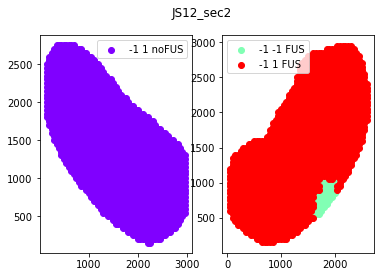

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3051: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS' '1,-1,FUS']
4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


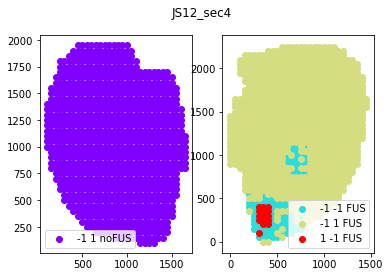

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')
['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS']
3


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


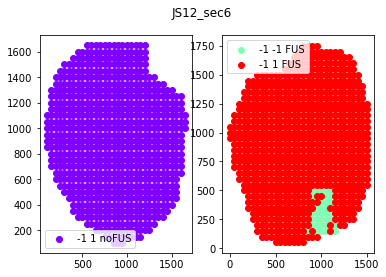

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, 1, 'FUS')
(-1, 1, 'noFUS')
['-1,1,FUS' '-1,1,noFUS']
2


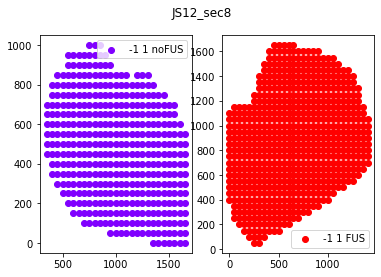

['sec2' 'sec4' 'sec6' 'sec8']
(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS' '1,-1,FUS']
4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

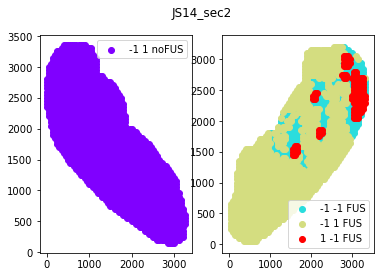

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS' '1,-1,FUS']
4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


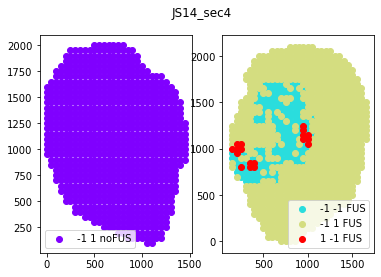

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS' '1,-1,FUS']
4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


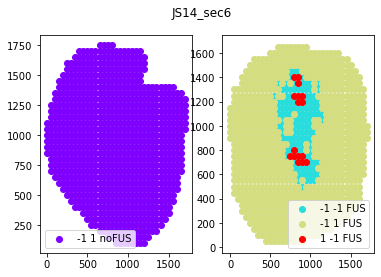

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-1, -1, 'FUS')
(-1, 1, 'FUS')
(-1, 1, 'noFUS')
(1, -1, 'FUS')
['-1,-1,FUS' '-1,1,FUS' '-1,1,noFUS' '1,-1,FUS']
4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


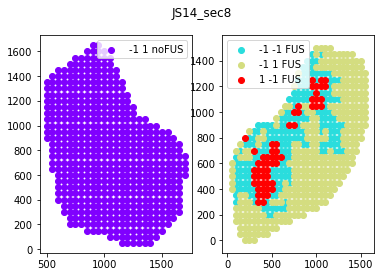

[]
done


In [313]:
#'''
#D7_100_single = mice_7d.loc[(mice_7d['Boxsize'] == 100) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_100_paired = mice_7d.loc[(mice_7d['Boxsize'] == 100) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_125_single = mice_7d.loc[(mice_7d['Boxsize'] == 125) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_125_paired = mice_7d.loc[(mice_7d['Boxsize'] == 125) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_150_single = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_150_paired = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='paired_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_150_single_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & (mice_7d['Day']=='untreated')]
#D7_150_paired_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='paired_threshold') & (mice_7d['Day']=='untreated')]
#'''



#print(wako_iba1_trt.columns.values)

#to_use_features='IntDen+Area+Mean+nEnds+totalBranchLength+cell_counts+ave_soma_size'.split("+")

to_use_features = "Area+Mean+D+cell_counts+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple+nEnds+totalBranchLength+Perim.".split("+")

    
#print(np.setdiff1d(wako_iba1_trt.columns.values, np.array(to_use_features)))
#to_use_features=['IntDen']
#0.05   0.12  22.0    0.080772

#0.20   0.14  18.0    0.094733

'''
#abcam iba1


gamma = 0.25
nu = 0.1
minN = 18
pca=True
n_pca=9
'''

#'''
#wako_iba1
gamma = 0.2
nu = 0.18
minN = 18

#gamma = 0.2
#nu = 0.18
#minN = 26
pca=True
n_pca=9
#'''

con = 'noFUS'
trt = 'FUS'
micro_clusters = []
micro_pca_models = []
#for df in [D7_150_single,D7_150_paired]:
#for df in [D7_150_paired]:

#print(wako_iba1_trt.columns.values)
#stop

#all_candidate_features = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','totalBranchLength'] #'nJuncVoxels', #'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'nTriple', 'aveBranch',


#print(wako_iba1_trt.loc[(wako_iba1_trt['ID']=='JS12') & (wako_iba1_trt['Section']=='sec2')])

#stop

#for f in to_use_features:
    #print(f)

return_pca_model=False
for df in [wako_iba1_trt2]:
#for df in [abcam_iba1_trt]:
    #micro_clusters.append(cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.1,minN=18,features=['Mean','Area','D'])) #"D","ave_soma_size","ave_nnd",IntDen #gamma=0.1,nu=0.1,minN=20

    #clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.08,minN=14,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=return_pca_model, focal_feature='IntDen')

    #clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.1,nu=0.06,minN=36,features=all_candidate_features, pca=True, n_pca=11, return_pca_model=return_pca_model,focal_minN=8, focal_feature='IntDen')

    #clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.2,nu=0.2,minN=18,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=return_pca_model, focal_feature='IntDen')


    #clusters = cluster_microglia(df,control=con,treatment=trt,gamma=0.2,nu=0.13,minN=16,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=return_pca_model, focal_feature='IntDen')


    clusters = cluster_microglia(df,control=con,treatment=trt,gamma=gamma,nu=nu,minN=minN,features=to_use_features, pca=pca, n_pca=n_pca, return_pca_model=return_pca_model, focal_feature='Mean')

    if return_pca_model:
        micro_pca_models.append(clusters[1])
        clusters = clusters[0]

    micro_clusters.append(clusters)
    #astro_clusters.append(cluster_astrocytes(df,control=con,treatment=trt,features=["D",'Mean','Area']))

micro_clusters = pd.concat(micro_clusters)

boxsize=150
for cluster in [micro_clusters]:
    #for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:

    print(f"=============== {to_use_features} ================")
    print(f"-----------------------------------")
    print(f"-----------------------------------")
    print(f"-----------------------------------")
    #for ID in ['JS83','JS84','JS85','JS89','JS90']:
    for ID in ['JS12','JS14']:
        ID_df = cluster.loc[cluster['ID']==ID]

        print(np.unique(ID_df['Section']))
        for sec in list(np.unique(ID_df['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Boxsize']==boxsize]
                f = 'outlier'
                plot_biplot(s,features=['BX','BY',f],colour_features=['focal_clusters','unclustered'],control=con,treatment=trt,plot_features=False,vmin=-3,vmax=3,label_clusters=True)

write_clusters=False
if write_clusters:
    #write iba1-gfap-ki67 cluster files
    _set = 'set1'
    write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='iba1',
                                                  #path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/{_set}/cluster_files/cluster_coordinates/"
                                                  path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'],
                                                 write_unclustered=True, unclustered_reference = 'combined_clusters', unclustered_output="unclustered")






#astro_clusters = pd.concat(astro_clusters)
#'''



#micro_untreated = cluster_microglia(D7_150_single_untr,control='L',treatment='R',gamma=0.1,nu=0.12,minN=16,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=False)
#micro_untreated = cluster_microglia(D7_150_single_untr,control='L',treatment='R',gamma=0.1,nu=0.08,minN=14,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=False)

#micro_untreated = cluster_microglia(D7_150_single_untr,control='L',treatment='R',gamma=0.1,nu=0.06,minN=36,features=all_candidate_features, pca=True, n_pca=11, focal_minN=8, return_pca_model=False)

#write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='microglia', clusters=['focal_clusters','proximal_clusters','combined_clusters','subtracted_clusters'])

#write_cluster_files_groupby_boxsize_threshold(astro_clusters,cell='astrocyte',clusters=['proximal_clusters'])

print(micro_pca_models)
print('done')


In [272]:
#xs = [0, 100, 100, 200, 200, 1000, 2000, 3000, 4000, 5000]
#ys = [0, 100, 200, 100, 200, 1000, 2000, 3000, 4000, 5000]

xs = []
ys = []

boxsize = 100.0

for i in range(20, 60):
    for j in range(20, 60):
        xs.append(i * boxsize/2)
        ys.append(j * boxsize/2)
        
#for i in range(0, 20)
        
        

df = pd.DataFrame(data = list(zip(xs,ys)), columns=['BX','BY'])


eps = math.sqrt((boxsize**2)*2)

print(eps)


print(dbscan_cluster(df, minN=26, eps=eps))



141.4213562373095
minN:  26 epsilon:  141.4213562373095
          BX      BY  proximal_clusters
0     1000.0  1000.0                 -1
1     1000.0  1050.0                 -1
2     1000.0  1100.0                 -1
3     1000.0  1150.0                 -1
4     1000.0  1200.0                 -1
...      ...     ...                ...
1595  2950.0  2750.0                 -1
1596  2950.0  2800.0                 -1
1597  2950.0  2850.0                 -1
1598  2950.0  2900.0                 -1
1599  2950.0  2950.0                 -1

[1600 rows x 3 columns]


In [ ]:
to_use_features = "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim.".split("+")
to_use_features = "Area+Mean+nBranches+nEnds+nTriple+nJuncVoxels".split("+")
to_use_features = "Area+Mean+nJunctions+nEnds+nTriple+Perim.".split("+")
to_use_features = "IntDen+Mean+nBranches+nJunctions+nEnds+nSlab+nTriple+Perim.+nJuncVoxels".split("+")
to_use_features = "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim.".split("+")

#to_use_features = "IntDen+Mean+nJunctions+nEnds+nSlab+nTriple+Perim.+nJuncVoxels".split("+") #w 0.2, 0.12, 20.0  = good for PCA 0.7 or no PCA <----
to_use_features = "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim.".split("+") #w 0.2, 0.12, 20.0  = good w 0.7 PCA <----


#to_use_features = "Area+Mean+nBranches+nJunctions+nEnds+nSlab+nTriple+Perim.".split("+") #0.2, 0.12, 20.0 = best so far
#to_use_features = "IntDen+Area+Mean+nBranches+nJunctions+nEnds+nSlab+Perim.".split("+")

#to_use_features = "IntDen+Area+Mean+nEnds+nTriple+Perim.+nJuncVoxels".split("+")

#IntDen+Area+Mean+nEnds+nSlab+nTriple+Perim.+nJuncVoxels
#to_use_features = [0.20   0.12  20.0    0.192042]


#0.35   0.20  22.0    0.092983
#0.30   0.20  22.0    0.091388
#0.25   0.14  20.0    0.085078

#0.20   0.20  22.0
#'''
#novus gfap
gamma = 0.2
nu = 0.14
minN = 20.0
pca=True
n_pca=5
#'''

'''
#santacruz gfap
gamma = 0.2
nu = 0.08 
minN = 22.0 
n_pca=5
'''

con='noFUS'
trt = 'FUS'

df = novus_gfap_trt
#df = sc_gfap_trt


gfap_clusters_treat, pca_models = cluster_astrocytes(df,control=con,treatment=trt,scale='standard',features=to_use_features,cells=['gfap'],n_pca=n_pca,pca=pca,return_pca_model=True, gamma=gamma, nu=nu, minN=minN,extra_scalers=['StdDev','Area','Circ.','IntDen','Round','Median','Mean','Mode','nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','nQuad','maxBranch','totalBranchLength','FeretX','FeretY','Perim.'])

#ctrl='R'
#trt='L'
boxsize=150

for cluster in [gfap_clusters_treat]:
    #for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:

    print(f"=============== {to_use_features} ================")
    print(f"-----------------------------------")
    print(f"-----------------------------------")
    print(f"-----------------------------------")
    #for ID in ['JS83','JS84','JS85','JS89','JS90']:
    for ID in ['JS12v3','JS13v3','HS14v3','JS16v3']:
    #for ID in ['JS12','JS14','JS13','JS16']:
        ID_df = cluster.loc[cluster['ID']==ID]

        print(np.unique(ID_df['Section']))
        for sec in list(np.unique(ID_df['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Boxsize']==boxsize]
                f = 'D'
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters','unclustered'],control=con,treatment=trt,plot_features=False,vmin=-3,vmax=3,label_clusters=True)

write_coords = True
if write_coords:
    _set='gfap_set_final'
    #_set='set1'
    write_cluster_files_groupby_boxsize_threshold(gfap_clusters_treat,cell='gfap',
                                                  path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/cluster_files/cluster_coordinates"
                                                  #path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters'], unclustered_reference='proximal_clusters', write_unclustered=True)


In [ ]:
#iba1_tgf1b_cd68 dataset  //  iba1 ter119 cd68


D7_150_single = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & ~(mice_7d['Day']=='untreated')]
#D7_150_single_untr = mice_7d.loc[(mice_7d['Boxsize'] == 150) & (mice_7d['Threshold']=='single_threshold') & (mice_7d['Day']=='untreated')]


con = 'noFUS'
trt = 'FUS'
#'''
micro_clusters = []
micro_pca_models = []


print(D7_150_single.columns.values)

all_candidate_features = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','totalBranchLength'] #'nJuncVoxels', #'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'nTriple', 'aveBranch',

return_pca_model=True
for df in [D7_150_single]:
    clusters = cluster_microglia(df,cells=['iba1'],control=con,treatment=trt,gamma=0.2,nu=0.13,minN=16,features=all_candidate_features, pca=True, n_pca=8, return_pca_model=return_pca_model, focal_feature='IntDen')
    if return_pca_model:
        micro_pca_models.append(clusters[1])
        clusters = clusters[0]
        
    micro_clusters.append(clusters)
    
micro_clusters = pd.concat(micro_clusters)

print(micro_pca_models)
print('done')


In [ ]:
_ = D7_150_single.loc[(D7_150_single['ID']=='JS3') & (D7_150_single['Section']=='sec6')]
print(_[all_candidate_features+['Treatment']])

In [ ]:
import matplotlib.pyplot as plt

for model in pca_models:
    xs = np.arange(0,len(model.explained_variance_ratio_),1)
    ys = model.explained_variance_ratio_
    plt.scatter(xs, ys)

    plt.show()

In [ ]:
for model in micro_pca_models[0]:
    df = pd.DataFrame(model.components_, columns=all_candidate_features)#all_scalar_features)
    display(df)
    
    loadings = model.components_.T * np.sqrt(model.explained_variance_ratio_)
    df2 = pd.DataFrame(list(zip(*loadings)), columns=all_candidate_features)#all_scalar_features)
    display(df2.sum().abs())
    
    print(loadings.shape)
    
    
    stop

In [ ]:
_set='gfap_set2'
write_cluster_files_groupby_boxsize_threshold(gfap_clusters_treat,cell='gfap',path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/cluster_files/cluster_coordinates"
                                                  ,clusters=['proximal_clusters'], unclustered_reference='proximal_clusters', write_unclustered=True)

In [ ]:
#write microglia cluster files
_set = 'Iba1_set4'
write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='microglia',path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'])

In [ ]:
#write iba1-tgf1b-cd68 cluster files
_set = 'set1'
#write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='iba1',path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/{_set}/cluster_files/cluster_coordinates/"
#                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'])

write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='iba1',path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_tgf1b_cd68/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'])

In [ ]:
#write iba1-gfap-ki67 cluster files
_set = 'set1'
write_cluster_files_groupby_boxsize_threshold(micro_clusters,cell='iba1',path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters','focal_clusters','subtracted_clusters','combined_clusters'])

In [ ]:
#write iba1-gfap-ki67 cluster files
_set = 'set1'
write_cluster_files_groupby_boxsize_threshold(gfap_clusters_treat,cell='gfap',path=f"E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/{_set}/cluster_files/cluster_coordinates/"
                                                  ,clusters=['proximal_clusters'])

In [ ]:
###
# plot clusters
#################
#ctrl='R'
#trt='L'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150


print(micro_clusters.columns.values)

for cluster in [micro_clusters]:
#for cluster in [micro_untreated]:
    #for ID in ['JS12', 'JS13', 'JS14', 'JS16']:
    #for ID in ['JS17v2']:
    for ID in ['JS1']:
        
        print(np.unique(cluster['Section']))
        print(list(np.unique(cluster['Section'])))
        #for sec in ['sec4','sec2']:
        #for sec in ['sec2re']:
        for sec in list(np.unique(cluster['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Threshold']==thresh]
                s = s.loc[s['Boxsize']==boxsize]
                '''
                for i in ['L','R']:
                    x=s.loc[s['Treatment']==i,'ave_nnd'].dropna()
                    plt.hist(x, normed=True, bins=15)
                    plt.show()
                '''
                f = 'outlier'
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters','focal_clusters'],control=ctrl,treatment=trt,plot_features=False,vmin=-2,vmax=2,label_clusters=True)
                
#['Area', 'Mean','IntDen', 'D', 'nBranches', 'nJunctions', 'nEnds','nSlab', 'aveBranch', 'nTriple', 'maxBranch', 'totalBranchLength',
#'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity']

In [ ]:
ctrl='R'
trt='L'

ctrl = 'noFUS'
trt = 'FUS'
#thresh='single_threshold'
boxsize=150

#test = branch_df[branch_df['ID']=='JS12']


#for cluster in [gfap_clusters]:
#for cluster in [gfap_clusters_treat]:
#    for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:
    
    
#print(np.unique(gfap_clusters['ID']))
#print(gfap_clusters.loc[gfap_clusters['ID']=='JS17'])

    
    
for cluster in [gfap_clusters_treat]:
    #for ID in ['JS12v3','JS13v3','JS14v3','JS16v3']:
    
    cluster = cluster.loc[((cluster['ID']=='JS14v3') & (cluster['Section']=='sec2')) | ((cluster['ID']=='JS12v3') & (cluster['Section']=='sec4'))]
    for ID in ['JS12v3','JS14v3']:
    #for ID in ['JS83','JS84','JS85','JS89','JS90']:
    #for ID in ['JS14v3']:
    #for ID in ['JS17']:
        
        
        ID_df = cluster.loc[cluster['ID']==ID]
        
        print(np.unique(ID_df['Section']))
        #for sec in ['sec4','sec2']:
        #for sec in ['sec2re']:
        for sec in list(np.unique(ID_df['Section'])):
            for thresh in ['single_threshold']:
                s = get_section(cluster,ID,sec)
                s = s.loc[s['Threshold']==thresh]
                s = s.loc[s['Boxsize']==boxsize]
                '''
                for i in ['L','R']:
                    x=s.loc[s['Treatment']==i,'ave_nnd'].dropna()
                    plt.hist(x, normed=True, bins=15)
                    plt.show()
                '''
                #['IntDen','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad', 'nJuncVoxels']
                #['IntDen','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad', 'nJuncVoxels']
                f = 'D'
                #for f in ['nEnds', 'StdDev', 'Perim.']:
                #for f in ['IntDen','Mode','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad', 'nJuncVoxels']:
                    #print(f"======== {f} =======")
                plot_biplot(s,features=['BX','BY',f],colour_features=['proximal_clusters','unclustered'],control=ctrl,treatment=trt,plot_features=False,vmin=-3,vmax=3,label_clusters=True)
                
                
#['IntDen',"D",'totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','nQuad','maxBranch']

In [ ]:
ID = 'TM1v3'
sec = 'sec6'
treatment = 'R'

xlabel=" "
ylabel="  "
labels = None
density_plot=False
#colours = ['b','y','r']
colours = 'inferno_r'



save=False
outputfile='19-6-26__JS12_FUS_sec2_microglia__heatmap_test.png'
#colour_features=['focal_clusters','proximal_clusters']

colour_features=['proximal_clusters']


#_sec = micro_clusters.loc[(micro_clusters['ID']==ID) & (micro_clusters['Section']==sec) & (micro_clusters['Treatment']==treatment)]

_sec = gfap_clusters.loc[(gfap_clusters['ID']==ID) & (gfap_clusters['Section']==sec) & (gfap_clusters['Treatment']==treatment)]


print(_sec.columns.values)

plot_mice(_sec,features=['BY','BX', 'D'],colour_features=colour_features,plot='heatmap',vmin=-8, vmax=1, #-8, 1
              xlabel=xlabel, ylabel = ylabel, labels=labels,colours = colours, save=save, outputfile=outputfile, invert_y=False, invert_x=False, legend_loc='upper right', legend_font=8, legend=False, cbar=False)

In [ ]:
ID = 'JS12'
sec = 'sec4'
treatment = 'FUS'

xlabel=" "
ylabel="  "
labels = None
density_plot=False
#colours = ['b','y','r']
colours = 'inferno'



save=False

outputpath = "C:/Users/joey_/__notebooks__/_python/morpheus_gliosis/"

outputfile='19-8-9__JS12_FUS_sec2_microglia__focal_clusters.png'
colour_features=['focal_clusters','proximal_clusters']

_sec = micro_clusters.loc[(micro_clusters['ID']==ID) & (micro_clusters['Section']==sec) & (micro_clusters['Treatment']==treatment)]


print(_sec.columns.values)

plot_mice(_sec,features=['BY','BX', 'focal_clusters'],colour_features=colour_features,plot='heatmap',vmin=-1, vmax=2.5, #-1, 1.5 for proximal
              xlabel=xlabel, ylabel = ylabel, labels=labels,colours = colours, save=save, outputfile=outputpath+outputfile, invert_y=False, invert_x=False, legend_loc='upper right', legend_font=8, legend=False, cbar=False)

In [ ]:
#graph elbow curve

import matplotlib.pyplot as plt
%matplotlib inline

ID = 'JS12'
sec = 'sec4'
treatment = 'FUS'

outputpath = "C:/Users/joey_/__notebooks__/_python/morpheus_gliosis/"

outputfile='19-7-29__JS12_FUS_sec2_microglia__threshold_graph.png'

_sec = micro_clusters.loc[(micro_clusters['ID']==ID) & (micro_clusters['Section']==sec) & (micro_clusters['Treatment']==treatment)]

focal_thresh = get_focal_threshold(_sec,feature='IntDen',subsetby="proximal_clusters")

#print(focal_thresh)



X = _sec.loc[_sec['proximal_clusters']==1,'IntDen'].sort_values().values

print(X)

fig = plt.figure()
fig.set_size_inches([2,2])
    
ax = plt.subplot(111)

#plt.xlabel("Proximal Outlier",fontsize=14)
plt.ylabel('IntDen',fontsize=10)

ax.plot(X, linewidth=3)
ax.axhline(y=focal_thresh,color='r', linestyle='-', linewidth=1.5)
ax = ax.set_xlabel('Proximal Outlier', fontsize=10)


#plt.axis('scaled')

#plt.figure(tight_layout=True)
save = False
if save:
    plt.tight_layout()
    fig.savefig(outputpath+outputfile, dpi=300)

#plt.show()



In [ ]:
import scipy.stats as sp

#'nBranches','nJunctions','nEnds','nJuncVoxels','nSlab','aveBranch','nTriple','maxBranch','totalBranchLength','Mean'
#all_feats = ['D','Median','Mean','IntDen','aveBranch','totalBranchLength','Area']
#all_feats = ['nEnds','Area','D']

all_feats = ['D','Mean','Area','Perim.','aveBranch','totalBranchLength']
plots = []
ind = 0
fig = plt.figure()

print(len(all_feats))

test = df_gfap[all_feats].dropna()

for i in range(1,len(all_feats)+1):
    for j in range(1,len(all_feats)+1):
        
        
        f1 = all_feats[i-1]
        f2 = all_feats[j-1]
        
        
        
        '''
        print(f1)
        print(f2)
        #feat1 = 'totalBranchLength'
        #feat2 = 'nTriple'
        corr = sp.pearsonr(test[f1],test[f2])
        print(corr)  
        pos = (i)*100 + len(all_feats)*10 + j
        print(pos)
        plots.append(fig.add_subplot(pos))
        plots[ind].scatter(test[feat1],test[feat2])
        plots[ind].text(2, 6, f'correlation: {corr[0]}', fontsize=15)
        '''
        corr = sp.pearsonr(test[f1],test[f2])
        
        print(corr)
        plt.scatter(test[f1],test[f2])
        plt.text(2, 6, f'correlation: {corr[0]}', fontsize=15)
       
        
        plt.xlabel(f1)
        plt.ylabel(f2)
        #ind += 1
        plt.show()

In [ ]:
###
# microglia_cluster PCA PLOT
#################
#'''

'''
start = time.time()
con = microglia_clusters_re.loc[microglia_clusters_re['Treatment'] == 'noFUS']
trt = microglia_clusters_re.loc[microglia_clusters_re['Treatment'] == 'FUS']
end = time.time()
'''

def plot_cluster_pca_density(_clusters,threshold='single_threshold',ID='JS12',sec='sec2',cell='microglia',
                             control='noFUS',treatment='FUS',
                             colour_features=["focal_clusters","subtracted_clusters","unclustered"],
                             labels=['focal','proximal','distal','untreated'],
                             colours=['Reds','Blues','Greens','Purples'],
                             xlabel='Principle Component 1', ylabel='Principal Component 2',
                             apply_pca = False, pca_features = [],
                             density_plot=True, save=False, outputfile=None):
    
    if apply_pca:
        con = _clusters.loc[(_clusters['Treatment'] == control) & (_clusters['Threshold'] == threshold)] #single_paired
        trt = _clusters.loc[(_clusters['Treatment'] == treatment) & (_clusters['Threshold'] == threshold)] #single_paired
        print(con.head())
        con, trt = pca_section(con,trt,n_comps=2,features=["Mean","D","ave_soma_size","ave_nnd"])
        con = _clusters.loc[(_clusters['Treatment'] == control) & (_clusters['Threshold'] == threshold)] #single_paired
        trt = _clusters.loc[(_clusters['Treatment'] == treatment) & (_clusters['Threshold'] == threshold)] #single_paired
        plot_pca = pd.concat([con,trt],ignore_index=True)
    else:
        plot_pca = _clusters

    _sec = plot_pca.loc[(plot_pca['ID'] == ID) & (plot_pca['Section'] == sec)]
    
    print(colour_features)
    
    plot_mice(_sec,features=["pca_0","pca_1"],colour_features=colour_features,
              xlabel=xlabel, ylabel = ylabel, labels=labels, density_plot=density_plot,colours = colours, save=save, outputfile=outputfile)
  
        

    '''
    ID = 'JS6'
    sec = 'sec2'

    astro_sec = astrocyte_clusters_re.loc[(astrocyte_clusters_re['ID'] == ID) & (astrocyte_clusters_re['Section'] == sec)]
    test_astros = astrocyte_clusters_re.loc[~((astrocyte_clusters_re['Treatment']=='noFUS')&(astrocyte_clusters_re['proximal_clusters']==1))]
    plot_mice(astro_sec,features=['Mean','D'],
              colour_features=['proximal_clusters','unclustered'],xlabel='Mean',ylabel='Fractal Complexity',
             colours=['orange','blue','gray'], labels=['proximal','distal','untreated'])

    '''
#_clusters = 
#gfap_clusters_treat
plot_cluster_pca_density(gfap_clusters_treat, threshold='single_threshold', ID='JS14v3', sec='sec2', density_plot=False, colour_features=['proximal_clusters','unclustered'],
                         labels=[], save=True, outputfile='19-6-10__astro_JS14v3_sec4.png',colours=['blue','green','yellow','red'])


In [281]:
from sklearn.model_selection import ParameterGrid


def setup_grid_ranges(gamma_range=[0.05,0.15,3],nu_range=[0.08,0.2,6],minN_range=[10,24,7], nPCs=None, nFeatures=1, auto_modifier=0.7):
    
    
    
    gammas = np.linspace(gamma_range[0],gamma_range[1],gamma_range[2])
    nus = np.linspace(nu_range[0],nu_range[1],nu_range[2])
    minNs = np.linspace(minN_range[0],minN_range[1],minN_range[2])
    
    #order gammas > nus > minNs > nfeats 
    param_grid = {'nu' : np.around(nus,decimals=2),
             'minN' : np.around(minNs,decimals=0),
             'gamma' : np.around(gammas, decimals=2)}
    
    if nPCs:
        if nPCs == 'auto':
            param_grid['nPCs'] = np.linspace(round(auto_modifier*nFeatures), round(auto_modifier*nFeatures), 1)
        else:
            nPCs = np.linspace(nPCs[0],nPCs[1],nPCs[2])
            param_grid['nPCs'] = np.around(nPCs)
            
            #print(param_grid['nPCs'])
        
    #print(param_grid)
    
    take2 = pd.DataFrame(list(ParameterGrid(param_grid)), columns=param_grid.keys())
    return take2


def grid_search2(mice,cell="microglia",features=[],control="L",treatment="R",reciprocal=False,
               kernel='rbf', gamma_range=[0.05,0.15,3],nu_range=[0.08,0.2,6], minN_range=[10,26,7],
                 pca=False, n_pca_range = [6,13,3],
               focal_cluster=False,focal_minN=5,focal_feature="IntDen",
               train_predict=False, summarize_clusters=False, summary_keys=['gamma','nu','min','ID','Section','train','test'], summary_clusters=['proximal_clusters']):
    
    mice = set_box_id(mice)
    if pca:
        summary_keys = summary_keys+['nPCs']
    
    print('... setting up grid ranges ...')
    
    if pca:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range, nPCs=n_pca_range, nFeatures = len(features))
    else:
        grids = setup_grid_ranges(gamma_range = gamma_range, nu_range=nu_range, minN_range = minN_range)
    
    grids.loc[:,'cluster_size'] = 0
    grids.loc[:,'num_outliers'] = 0
    
    
    iterations = 0
    num_iterations = len(grids)
    print(f"----- number of iterations: {num_iterations} -----")
    
    clusters = []
    
    levels=['gamma','nu','minN']
    if pca:
        #grids = grids.set_index(['gamma','nu','minN','nPCs'])
        levels = levels + ['nPCs']

    grids = grids.set_index(levels)
    
    for indexes, df in grids.groupby(level=levels):
        
        #print("=============================================================================================")
        #print(indexes)
        
        st = time.time()
        g = indexes[0]
        n = indexes[1]
        m = indexes[2]
        nPCs=0
        if pca:
            nPCs = indexes[3]
        if nPCs > 0:
            #print(f"nu: {n}, gamma: {g}, min: {m}, nPCs: {nPCs}")
            None
        else:
            #print(f"nu: {n}, gamma: {g}, min: {m}")
            None
        #print("============================================================================================")
        clust = iter_all(mice,cells=[cell],features=features,control=control,treatment=treatment,
                         kernel=kernel,gamma=g,nu=n,minN=int(m),pca=pca,n_comps=int(nPCs),return_pca_model=False,
                         focal_cluster=focal_cluster, focal_minN=focal_minN, focal_feature=focal_feature,
                         train_predict=train_predict)
        
        clust.loc[:,'gamma'] = g
        clust.loc[:,'nu'] = n
        clust.loc[:,'min'] = m
        clust.loc[:,'train'] = control
        clust.loc[:,'test'] = treatment
        if pca:
            clust.loc[:,'nPCs'] = nPCs
        
        if summarize_clusters:
            #print("--- summarizing ---")
            clust = summarize_cluster_grids(clust, keys=summary_keys, cluster_types=summary_clusters)
        clusters.append(clust)
        
        if reciprocal:
        
            clust = iter_all(mice,cells=[cell],features=features,control=treatment,treatment=control,
                                    kernel=kernel,gamma=g,nu=n,minN=int(m),pca=pca,n_comps=int(nPCs),
                                   focal_cluster=focal_cluster,focal_minN=focal_minN,focal_feature=focal_feature,
                            train_predict=train_predict)
            clust_size = len(clust.loc[clust['proximal_clusters'] > -1])
            clust.loc[:,'gamma'] = g
            clust.loc[:,'nu'] = n
            clust.loc[:,'min'] = m
            clust.loc[:,'train'] = treatment
            clust.loc[:,'test'] = control
            if pca:
                clust.loc[:,'nPCs'] = nPCs
            if summarize_clusters:
                print("--- summarizing ---")
                clust = summarize_cluster_grids(clust, keys=summary_keys, cluster_types=summary_clusters)
            clusters.append(clust)   
            
        iterations += 1
        if (iterations % 50) == 0:
            print(f"progress.. {iterations}/{num_iterations}")
        print(f"===== TIME FOR ITERATION {time.time()-st} =====")
    return pd.concat(clusters)

      
def plot_grid(grids,splitby='gamma',x='minN',y='nu',z='cluster_size',cmap='spectral',vmin=0,vmax=None):
    splits = grids.index.get_level_values(splitby).unique()
    fig = plt.figure()
    grids = grids[z]
    #print(grids)
    for plc, s in zip(range(len(splits)),splits):
        grid = grids.xs(s,level=splitby)
        grid = grid.reset_index()
        sub = 100 + len(splits)*10 + 1 +plc
        ax = fig.add_subplot(sub)
        #ax.title = s
        grid = grid.pivot(x, y, z)
        ax = sns.heatmap(grid,cmap=cmap,vmin=vmin,vmax=vmax)
    plt.show()

def rank_feats(grid,features=["Mean","IntDen","D"],target_feature="proximal_clusters"):
    corrs = {}
    target = grid[target_feature].convert_objects(convert_numeric=True)
    for f in features:
        result = stats.pointbiserialr(grid[f], target)
        corrs[f] = result
    return corrs

def find_top_parameters(sumgrid,control="noFUS",treatment="FUS",maxTreat=True,top=5):
    con_zeroes = sumgrid.loc[(sumgrid["clusters"]==0) & (sumgrid["Treatment"]==control)].set_index(["gamma","nu","minN"])
    treat = sumgrid.loc[(sumgrid["Treatment"]==treatment)].set_index(["gamma","nu","minN"])
    treat_cut = treat.loc[con_zeroes.index,:]
    return treat_cut.sort_values(by="clusters",ascending=not(maxTreat)).iloc[0:top]

def find_best_combo(sumgrids):
    re = pd.concat(sumgrids,axis=1)
    print(re)

def grid_search_cell_boxsize_threshold2(untr_mice,cells=['microglia','astrocyte'],features = {'microglia' : [["IntDen","D","ave_soma_size","ave_nnd"]],
                                                                                            'astrocyte' : [['Mean','Area','D']],
                                                                                            'gfap' : [['Mean','IntDen','D']]},
                                        pca=False,
                                      gamma_range=[0.05,0.16,3],nu_range=[0.04,0.16,4],minN_range=[10,28,9], n_pca_range=[4,12,3],
                                       control='L', treatment='R', reciprocal=True, 
                                        summarize_clusters=False, summary_keys=['gamma','nu','min','ID','Section','train','test'], summary_clusters=['proximal_clusters']):
    results = []
    cell_features = []
    for cell in cells:
        cell_features.append(features[cell])
    for thresh_type in pd.unique(untr_mice['Threshold']):
        print(f"thresh_type: {thresh_type}")
        for boxsize in pd.unique(untr_mice['Boxsize']):
            print(f"boxsize: {boxsize}")
            for cell,feats in zip(cells,cell_features):
                for f in feats:
                    #print('feats',feats)
                    #print('feats',f)

                    #print(cell,feats)
                    togrid = untr_mice.loc[(untr_mice['Threshold']==thresh_type) & (untr_mice['Boxsize']==boxsize)]
                    print('\n')
                    print(thresh_type,boxsize,cell,f)
                    print(len(togrid))
                    print("======================================================")
                    print("======================================================")
                    re = grid_search2(togrid,features=f,control=control,treatment=treatment,cell=cell,train_predict=False,reciprocal=reciprocal,gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range,pca=pca, n_pca_range = n_pca_range,
                                     summarize_clusters=summarize_clusters, summary_keys=summary_keys, summary_clusters=summary_clusters)
                    joined_feats = '+'.join(f)
                    for key, val in zip(['Threshold','Boxsize','CellType','Features'],[thresh_type,boxsize,cell,joined_feats]):
                        #print(key)
                        #print(val)
                        re.loc[:,key] = val
                    results.append(re)
    clusters = pd.concat(results)
    return clusters


def summarize_cluster_grids(clusters,keys=['gamma','nu','min','ID','Section','Threshold','Boxsize','CellType','Treatment','Features','nPCs'],cluster_types=['proximal_clusters']):
    #summary = clusters.loc[clusters['proximal_clusters']>-1,keys+cluster_types]
    #'''
    nClusts = {}
    for cl in cluster_types:
        nClusts[cl] = len(np.unique(clusters.loc[clusters[cl]>-1,cl]))
        clusters.loc[clusters[cl]>-1,cl] = 1
        clusters.loc[clusters[cl]==-1,cl] = 0
    #'''
    summary = clusters[keys+cluster_types]
    
    #summary = summary.loc[summary['proximal_clusters']>-1]
    summary = summary.groupby(keys)[cluster_types].agg(['sum','count'])
    summary.columns = summary.columns.map(''.join)
    for cl in nClusts.keys():
        #print(cl)
        #print(nClusts[cl])
        summary.loc[:,cl+"_nclusts"] = nClusts[cl]
    
    #print(summary)
    for cl in cluster_types:
        summary.loc[:,cl+'_perc_cluster'] = summary[cl+'sum'] / summary[cl+'count']
    return summary


def resummarize_cluster_grids(clusters,keys=['gamma','nu','min'], cols_to_summarize=['proximal_clusterssum','proximal_clusterscount'], cluster_types=['proximal_clusters']):
    summary = clusters.groupby(keys)[cols_to_summarize].sum()
    for cl in cluster_types:
        summary.loc[:,cl+'_perc_cluster'] = summary[cl+'sum'] / summary[cl+'count']
    return summary

print('done')

def round_parameters(cluster, cols=['gamma','nu']):
    for col in cols:
        cluster.loc[:,col] = np.around(cluster[col].values, decimals=2)
    return cluster

def find_best_parameters(untr, trt, keys=['gamma','nu','min'], cluster_metric='proximal_clusterssum'):
    untr = round_parameters(untr.reset_index())
    trt = round_parameters(trt.reset_index())
    
    untr = untr.set_index(keys)
    trt = trt.set_index(keys)
    
    candidate_params = untr.loc[untr[cluster_metric]==0]
    top = trt.loc[candidate_params.index,cluster_metric]
    print(top)
    top = top.sort_values(ascending=False)
    print(top)
    
def section_wise_cluster_assessment(df, assess_col='proximal_clusters_perc_cluster', remove_outlier_sections=True, return_inliers=False):
    df = df.loc[~((df['Section']=='sec8'))]
    #df = df.loc[~((df['ID']=='JS89')&(df['Section']=='sec6'))]
    #df = df.loc[~((df['ID']=='JS83')&(df['Section']=='sec4'))]
    #df = df.loc[~((df['ID']=='JS90')&(df['Section']=='sec6'))]
    df = df.loc[~(df['ID']=='JS90')]
    resumm = resummarize_cluster_grids(df, keys = ['ID','Section'])
    inliers = grubbs.test(resumm[assess_col], alpha=0.05)
    #inliers = resumm
    print(inliers)
    df = df.set_index(['ID','Section'])
    df = df.loc[inliers.index,:]
    if return_inliers:
        return df, inliers
    else:
        return df
    
def find_best_parameters(untr, trt, keys=['gamma','nu','min'], cluster_metric='proximal_clusterssum'):
    untr = round_parameters(untr.reset_index())
    trt = round_parameters(trt.reset_index())
    
    untr = untr.set_index(keys)
    trt = trt.set_index(keys)
    
    candidate_params = untr.loc[untr[cluster_metric]==0]
    
    top = trt.loc[candidate_params.index,cluster_metric]
    print(top)
    top = top.sort_values(ascending=False)
    print(top)
        
        
    

done


In [ ]:
####################################### FINE GRID SEARCH ALL ASTROCYTE CASES #######################################
#'''
'''
novus_gfap_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/",
                       set_ = "gfap_set_final",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'])
'''
'''
novus_gfap_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/",
                       set_ = "gfap_set_final",
                       IDs = ['JS12v3','JS13v3','JS14v3','JS16v3'])
'''
#'''
santacruz_gfap_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/santacruz_gfap/output/",
                       set_ = "set1",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'])

santacruz_gfap_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/",
                       set_ = "set1",
                       IDs = ['JS12','JS13','JS14','JS16'])

#'''

gamma_range = [0.05,0.45,9]
nu_range=[0.06,0.24,10]
minN_range = [14,26,7]
n_pca_range=[5,5,1]



path = "D:/Non_Dropbox__Put_files_you_do_not_want_syncd_here/Joey/__python_notebooks__/morpheus_gliosis/dataframes/"
date = '20-1-24'


all_features = ['IntDen','D','totalBranchLength','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','nTriple','maxBranch','Perim.','nQuad']


best_features = [["Area","Mean","nBranches","nJunctions","nEnds","nSlab","nTriple","Perim."],["Area","Mean","nJunctions","nEnds","nSlab","nTriple","Perim."]]

'''
novus_gfap_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/",
                       set_ = "gfap_set_final",
                       IDs = ['JS14v3','JS12v3'])
'''

'''
trt_df = novus_gfap_trt
data = []
for i in range(3,len(all_features)+1):
    for comb in combinations(all_features, i):
        st = time.time()
        comb = list(comb)
        print(comb)
        grid = grid_search_cell_boxsize_threshold2(trt_df.loc[(trt_df['ID']=='JS14v3') & (trt_df['Section']=='sec2')],cells=['gfap'],features={'gfap': [comb]},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
        data.append(grid)
        
grids = pd.concat(data)
grids.to_csv(path+f"{date}_FUS_MAXfeature_search_JS14v3-sec2.csv")
print(f".. saved ..")


data = []
for i in range(3,len(all_features)+1):
    for comb in combinations(all_features, i):
        st = time.time()
        comb = list(comb)
        print(comb)
        grid = grid_search_cell_boxsize_threshold2(trt_df.loc[(trt_df['ID']=='JS12v3') & (trt_df['Section']=='sec4')],cells=['gfap'],features={'gfap': [comb]},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
        data.append(grid)
        
grids = pd.concat(data)
grids.to_csv(path+f"{date}_FUS_MAXfeature_search_JS12v3-sec4.csv")
print(f".. saved ..")
'''       


#'''

#print(final_features_set)

#con_df, con_file, trt_df, trt_file
for con_df, con_file, trt_df, trt_file in [[santacruz_gfap_untr, 'santacruz_gfap_untreated', santacruz_gfap_trt,'santacruz_gfap_FUS_treated']]:
#for con_df, con_file, trt_df, trt_file in [[novus_gfap_untr, 'novus_gfap_untreated', novus_gfap_trt,'novus_gfap_FUS_treated']]:
    print(con_file, trt_file)
    
    grid = grid_search_cell_boxsize_threshold2(con_df,cells=['gfap'],features={'gfap': best_features},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                    control='R',treatment='L', reciprocal=True,
                                                      summarize_clusters=True)
    grid.to_csv(path+f"{date}_{con_file}_gridsearch_fine.csv")
    print(f".. saved {date}_{con_file} ..")
    
    #trt_df.loc[((trt_df['ID']=='JS14v3') & (trt_df['Section']=='sec2')) | ((trt_df['ID']=='JS12v3') & (trt_df['Section']=='sec4'))]
    grid = grid_search_cell_boxsize_threshold2(trt_df,cells=['gfap'],features={'gfap': best_features},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
    grid.to_csv(path+f"{date}_{trt_file}_gridsearch_fine.csv")
    print(f".. saved {date}_{trt_file} ..")
    
#'''  
    
    

'''
    
path = "D:/Non_Dropbox__Put_files_you_do_not_want_syncd_here/Joey/__python_notebooks__/morpheus_gliosis/dataframes/"
date = '20-1-17'

#con_df, con_file, trt_df, trt_file
#for con_df, con_file, trt_df, trt_file in [[novus_gfap_untr, 'novus_gfap_untreated', novus_gfap_trt,'novus_gfap_FUS_treated'],[santacruz_gfap_untr, 'santacruz_gfap_untreated', santacruz_gfap_trt,'santacruz_gfap_FUS_treated']]:
for con_df, con_file, trt_df, trt_file in [[novus_gfap_untr, 'novus_gfap_untreated', novus_gfap_trt,'novus_gfap_FUS_treated']]:
    print(con_file, trt_file)
    
    grid = grid_search_cell_boxsize_threshold2(con_df,cells=['gfap'],features={'gfap': [feature_set5]},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                    control='R',treatment='L', reciprocal=True,
                                                      summarize_clusters=True)
    grid.to_csv(path+f"{date}_{con_file}_pca4.csv")
    print(f".. saved {date}_{con_file}_pca4.csv ..")
    
    grid = grid_search_cell_boxsize_threshold2(trt_df,cells=['gfap'],features={'gfap': [feature_set5]},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
    grid.to_csv(path+f"{date}_{trt_file}_pca4.csv")
    print(f".. saved {date}_{trt_file}_pca4.csv ..")
    
'''


In [ ]:
path = "D:/Non_Dropbox__Put_files_you_do_not_want_syncd_here/Joey/__python_notebooks__/morpheus_gliosis/dataframes/"
con_file = "20-1-24_santacruz_gfap_untreated_gridsearch_fine.csv"
trt_file = "20-1-24_santacruz_gfap_FUS_treated_gridsearch_fine.csv"

astr_untr = pd.read_csv(path+con_file)
astr_trt = pd.read_csv(path+trt_file)

#__ = astr_trt.groupby(['gamma','nu','min','Features'])['proximal_clusters_perc_cluster'].mean().sort_values(ascending=False)
#__.to_csv(path+"20-1-20__summarized_sorted_MAXfeatures.csv")



for feature_set in astr_untr['Features'].unique():
    print('----- feature_set -----')
    print(feature_set)
    print('----- feature_set -----')
    
    con = astr_untr.loc[astr_untr['Features']==feature_set]
    trt = astr_trt.loc[astr_trt['Features']==feature_set]
    
    untr_cut = section_wise_cluster_assessment(con)
    #trt = astr_trt.loc[~(trt['Section']=='sec8')]
    #trt = trt.loc[(trt['ID']=='JS14v3')&(trt["Section"]=='sec2')]
    
    #__ = trt.groupby(['gamma','nu','min'])['proximal_clusters_perc_cluster'].mean().sort_values(ascending=False)
    find_best_parameters(resummarize_cluster_grids(untr_cut, keys = ['gamma','nu','min']), resummarize_cluster_grids(trt, keys = ['gamma','nu','min']), cluster_metric='proximal_clusters_perc_cluster')
    
    
#astr_trt = astr_trt.loc[~(astr_trt['Section']=='sec8')]




0
2
0
2
0
2
0
2
0
2
0
2
0
2
0
2
0
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2


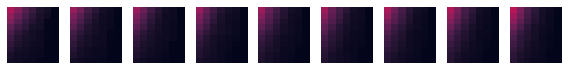

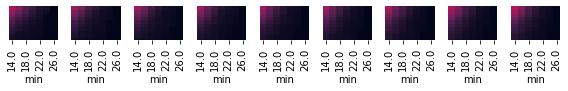

In [41]:
#'''
#copy_astro_trt = copy.copy(cluster_grid_trt)

#path = "D:/Non_Dropbox__Put_files_you_do_not_want_syncd_here/Joey/__python_notebooks__/morpheus_gliosis/dataframes/"
path = "D:/dataframes/"
con_file = "20-1-24_santacruz_gfap_untreated_gridsearch_fine.csv"
trt_file = "20-1-24_santacruz_gfap_untreated_gridsearch_fine.csv"

outputpath = "C:/Users/joey_/__notebooks__/_python/morpheus_gliosis/grid_search_pics/"

_untr = pd.read_csv(path+con_file)
_trt = pd.read_csv(path+trt_file)


dat = _untr

_untr = _untr.loc[_untr['Features'] == "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim."]
_trt = _trt.loc[_trt['Features'] == "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim."]
'''
for feature_set in dat['Features'].unique():
    print('----- feature_set -----')
    print(feature_set)
    print('----- feature_set -----')
    
    grid = dat.loc[astr_untr['Features']==feature_set]
    grid = resummarize_cluster_grids(grid, keys = ['gamma','nu','min'])

    pd.options.display.max_rows = 500

    save=False
    
    for lamb in grid.index.get_level_values('gamma').unique():

        outputfile = f"19-7-30__astrocyte_treated_grid_search_lamda={lamb}.png"
        _pivot = grid.xs(lamb,level='gamma').reset_index()
        _pivot = _pivot.pivot('nu','min','proximal_clusters_perc_cluster')

        fig = plt.figure()
        fig.set_size_inches([2,2])
        ax = plt.subplot(111)

        sns.heatmap(_pivot, annot=False, vmin=0, vmax=0.18, cbar=False)
        ax.invert_yaxis()
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 

        #ax.set_xlabel('Min #outliers', fontsize=12)
        #ax.set_ylabel('Nu', fontsize=12)
        #ax.set_title(f'Lambda: {lamb}')

        plt.tight_layout()

        for label in ax.get_xticklabels():
            if (int(float(label.get_text())) - 10) % 4 == 0:  
                label.set_visible(True)
            else:
                label.set_visible(False)

        for label in ax.get_yticklabels():
            if (int(float(label.get_text())*100) % 4 == 0):  
                label.set_visible(True)
            else:
                label.set_visible(False)

        ax.plot()
        if save:
            fig.savefig(outputpath+outputfile, dpi=300)
'''   

def plot_grid_search(dfs, keys = ['gamma','nu','min'], save=False, dimensions=[8,2], outputfile = f"19-7-30__astrocyte_treated_grid_search_lamda={lamb}.png"):
    y=0
    for df in dfs:
        grid = resummarize_cluster_grids(df, keys = keys)

        pd.options.display.max_rows = 500

        save=False

        fig = plt.figure()
        fig.set_size_inches(dimensions)
        fig.set_constrained_layout(False)

        n_lamb = len(grid.index.get_level_values('gamma').unique())
        n=1
        for lamb in grid.index.get_level_values('gamma').unique():

            _pivot = grid.xs(lamb,level='gamma').reset_index()
            _pivot = _pivot.pivot('nu','min','proximal_clusters_perc_cluster')

            plot_n = str(len(dfs))+str(n_lamb)+str(n)
            ax = plt.subplot(plot_n)

            sns.heatmap(_pivot, annot=False, vmin=0, vmax=0.18, cbar=False)
            ax.invert_yaxis()
            
            print(y)
            print(len(dfs))
            
            ax.axes.get_yaxis().set_visible(False)
            ax.axes.get_xaxis().set_visible(False)
            
            if y == 1:
                ax.axes.get_xaxis().set_visible(True)

            #ax.set_xlabel('Min #outliers', fontsize=12)
            #ax.set_ylabel('Nu', fontsize=12)
            #ax.set_title(f'Lambda: {lamb}')

            plt.tight_layout()

            for label in ax.get_xticklabels():
                if (int(float(label.get_text())) - 10) % 4 == 0:  
                    label.set_visible(True)
                else:
                    label.set_visible(False)
            '''
            for label in ax.get_yticklabels():
                if (int(float(label.get_text())*100) % 4 == 0):  
                    label.set_visible(True)
                else:
                    label.set_visible(False)
            '''
            n+=1
        y+=1

    
    
    plt.plot()
    if save:
        fig.savefig(outputpath+outputfile, dpi=300)
        
        
plot_grid_search([_untr,_trt])
        

            
            


ID    Section
JS83  sec2       0.000254
      sec4       0.022326
      sec6       0.000835
JS84  sec2       0.018199
      sec4       0.015102
      sec6       0.015711
JS85  sec2       0.002056
      sec4       0.005562
      sec6       0.011510
JS89  sec2       0.004041
      sec4       0.002365
      sec6       0.021301
Name: proximal_clusters_perc_cluster, dtype: float64


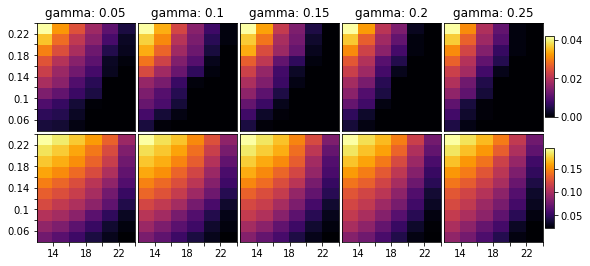

In [295]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

#arr = np.arange(100).reshape((10, 10))

def plot_gridsearch2(dfs,keys = ['gamma','nu','min'], figsize=(8,3.5), col_dim='gamma', save=False, outputpath="", outputfile="", vmax=0.15):
    fig_rows = len(dfs)
    fig_cols = len(dfs[0]['gamma'].unique())
    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=figsize, constrained_layout=True)
    n=0
    
    #print(axs.flat[0])
    #stop
    
    for df in dfs:
        vmax = max(df['proximal_clusters_perc_cluster'])
        norm = mcolors.Normalize(vmin=0., vmax=vmax)
        pc_kwargs = {'rasterized': True, 'cmap': 'inferno'}#, 'norm': norm}
        grid = resummarize_cluster_grids(df, keys = keys)
        for gamma in grid.index.get_level_values('gamma').unique():
            _pivot = grid.xs(gamma, level='gamma').reset_index()
            _pivot = _pivot.pivot('nu','min','proximal_clusters_perc_cluster')

            #arr2 = grid.xs(gamma,level='gamma').reset_index()['proximal_clusters_perc_cluster'].values
            #arr2 = arr2.reshape((7,10))
            ax = axs.flat[n]
            im = ax.pcolormesh(_pivot, **pc_kwargs)
            
            
            #ax.set_xticks([14,16,18,20,22,26]) 
            #ax.set_xticklabels([14,16,18,20,22,26])
            #ax.xticks(np.arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
            if n % fig_cols != 0:
                ax.axes.get_yaxis().set_visible(False)
            if n < fig_cols:
                ax.axes.get_xaxis().set_visible(False)
                ax.set_title(f'gamma: {gamma}')
            n+=1
        kwargs = {'format': '%.2f'}
        fig.colorbar(im, ax=ax, shrink=0.75, **kwargs)
    plt.setp(axs, xticks=[1, 2, 3, 4, 5, 6], xticklabels=[14,'',18,'',22,''],
        yticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], yticklabels=[0.06, '', 0.1, '', 0.14, '', 0.18, '', 0.22, ''])
    
    #plt.setp(axs, xticks=[1, 2, 3, 4, 5, 6, 7, 8], xticklabels=[14, 16, 18, 20, 22, 24, 26], yticks=[1, 2, 3])
    fig.set_constrained_layout_pads(w_pad=0, h_pad=0,
        hspace=0., wspace=0.)
    
    if save:
        fig.savefig(outputpath+"/"+outputfile, dpi=300)
        
def prune_sections(df):
    pruned = section_wise_cluster_assessment(df)
    indeces = pruned.index.unique()
    df = df.set_index(['ID','Section'])
    return df.loc[indeces,:].reset_index()
        
    
        
#plot_gridsearch2([_untr,_trt])

outputpath = "C:/Users/joey_/__notebooks__/_python/morpheus_gliosis/grid_search_pics/"
path = "D:/dataframes/"

'''
con_file = "20-1-21_novus_gfap_untreated_gridsearch_fine.csv"
trt_file = "20-1-21_novus_gfap_FUS_treated_gridsearch_fine.csv"
outputfile = "20-2-6__novus_gfap_gridsearch"
features = "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim."
'''

'''
con_file = "20-1-24_santacruz_gfap_untreated_gridsearch_fine.csv"
trt_file = "20-1-24_santacruz_gfap_FUS_treated_gridsearch_fine.csv"
outputfile = "20-1-31__santacruz_gridsearch"
features = "Area+Mean+nJunctions+nEnds+nSlab+nTriple+Perim."
'''
'''
con_file = "20-1-22_wako_iba1_untreated_finegrid.csv"
trt_file = "20-1-22_wako_iba1_FUS_treated_v2_finegrid.csv"
outputfile = "20-1-31__wako_iba1_gridsearch"
features = "Area+Mean+D+cell_counts+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple+nEnds+totalBranchLength+Perim."

'''
'''
con_file = "20-1-22_abcam_iba1_untreated_finegrid.csv"
trt_file = "20-1-22_abcam_iba1_FUS_treated_finegrid.csv"
outputfile = "20-1-31__abcam_iba1_gridsearch"
features = "Area+Mean+D+cell_counts+ave_nnd+ave_soma_size+ave_soma_circularity+nJunctions+nBranches+nTriple+nEnds+totalBranchLength+Perim."

'''

_untr = pd.read_csv(path+con_file)
_trt = pd.read_csv(path+trt_file)

_untr = _untr.loc[_untr['Features'] == features]
_trt = _trt.loc[_trt['Features'] == features]

_untr = _untr.loc[_untr['gamma']<0.3]
_trt = _trt.loc[_trt['gamma']<0.3]

_untr = _untr.loc[_untr['min']<26]
_trt = _trt.loc[_trt['min']<26]

_untr = prune_sections(_untr)
#print(_trt.head())
#print(_untr.head())


plot_gridsearch2([_untr,_trt], save=True, outputpath=outputpath, outputfile=outputfile, vmax=0.15)

In [19]:
####################################### FINE GRID SEARCH ALL MICROGLIA CASES #######################################
'''
wako_iba1_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/wako_iba1/output/",
                       set_ = "set1",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'],
                                   count_data=True,
                                   celltypes=['iba1'])
'''
wako_iba1_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/",
                       #set_ = "Iba1_set2",
                                   set_ = "set1",
                       IDs = ['JS12', 'JS13', 'JS14', 'JS16'],
                                   count_data=True,
                                   celltypes=['iba1'])

'''
#wako_iba1_trt.loc[:,'CellType'] = 'iba1'
'''

#'''
abcam_iba1_untr = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/abcam_iba1/output/",
                       set_ = "set1",
                       IDs = ['JS83', 'JS84', 'JS85', 'JS89', 'JS90'],
                                   count_data=True,
                                   celltypes=['iba1'])

abcam_iba1_trt = compile_feature_df(base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/",
                       set_ = "set1",
                       IDs = ['JS12', 'JS13', 'JS14', 'JS16'],
                                   count_data=True,
                                   celltypes=['iba1'])
#'''
#print(wako_iba1_untr.head())
#print(wako_iba1_trt.head())

#feature_set1 = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple']
'''
all_feature_combos = []
all_features = ['IntDen','D','Area','Mean','nBranches','nJunctions','nEnds','nSlab','aveBranch','totalBranchLength','nTriple','Perim.','cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity']
for r in range(6,len(all_features)+1):
    for comb in itertools.combinations(all_features, r):
        #print(list(comb))
        #stop
        all_feature_combos.append(list(comb))
'''
        

gamma_range = [0.05,0.45,9]
nu_range=[0.06,0.24,10]
minN_range = [14,26,7]
#n_pca_range=[5,5,1]
n_pca_range='auto'

#gamma_range = [0.15, 0.2, 2]
#nu_range = [0.08,0.12,3]
#minN_range = [16,20,3]
#n_pca_range = 'auto'



path = "D:/Non_Dropbox__Put_files_you_do_not_want_syncd_here/Joey/__python_notebooks__/morpheus_gliosis/dataframes/"
date = '20-1-22'

'''

grid = grid_search_cell_boxsize_threshold2(wako_iba1_trt,cells=['iba1'],features={'iba1': [feature_set1]},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
grid.to_csv(path+f"{date}_{trt_file}_finegrid.csv")
print(f".. saved {date}_{trt_file}_finegrid.csv ..")
'''


#feature_set1 = ['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','totalBranchLength', 'aveBranch', 'maxBranch', 'Perim.']

feature_set1 = [
    #["IntDen","Area","Mean","nEnds","totalBranchLength","cell_counts","ave_soma_size"],
    ["Area","Mean","D","cell_counts","ave_nnd","ave_soma_size","ave_soma_circularity","nJunctions","nBranches","nTriple","nEnds","totalBranchLength","Perim."]
]


'''
trt_df = wako_iba1_trt
trt_file = "wako_iba1"


grid = grid_search_cell_boxsize_threshold2(trt_df,cells=['iba1'],features={'iba1': all_top_features},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
grid.to_csv(path+f"{date}_{trt_file}_feature_search_JS14_coarse.csv")
'''


#for con_df, con_file, trt_df, trt_file in [[abcam_iba1_untr, 'abcam_iba1_untreated', abcam_iba1_trt,'abcam_iba1_FUS_treated']]:
for con_df, con_file, trt_df, trt_file in [[abcam_iba1_untr, 'abcam_iba1_untreated', abcam_iba1_trt,'abcam_iba1_FUS_treated']]:
#for con_df, con_file, trt_df, trt_file in [[wako_iba1_untr, 'wako_iba1_untreated', wako_iba1_trt,'wako_iba1_FUS_treated_v2']]:
    print(con_file, trt_file)

    #'''
    grid = grid_search_cell_boxsize_threshold2(con_df,cells=['iba1'],features={'iba1': feature_set1},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                    control='R',treatment='L', reciprocal=True,
                                                      summarize_clusters=True)
    grid.to_csv(path+f"{date}_{con_file}_finegrid.csv")
    print(f".. saved {date}_{con_file}_finegrid.csv ..")
    #'''
    grid = grid_search_cell_boxsize_threshold2(trt_df,cells=['iba1'],features={'iba1': feature_set1},
                                              gamma_range=gamma_range,nu_range=nu_range,minN_range=minN_range, pca=True, n_pca_range=n_pca_range,
                                                          control='noFUS', treatment='FUS', reciprocal=False,
                                                          summarize_clusters=True)
    grid.to_csv(path+f"{date}_{trt_file}_finegrid.csv")
    print(f".. saved {date}_{trt_file}_finegrid.csv ..")

                                   
                                   


JS12 : , True
cell: True
JS12_7D_FUS_iba1_sec2_150X150.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_iba1_sec4_150X150.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_iba1_sec6_150X150.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_FUS_iba1_sec8_150X150.txt :  ['JS12', '7D', 'FUS', 'iba1', 'sec8', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec2_150X150.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec2', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec4_150X150.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec4', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec6_150X150.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec6', '150X150.txt'] :  True
JS12 : , True
cell: True
JS12_7D_noFUS_iba1_sec8_150X150.txt :  ['JS12', '7D', 'noFUS', 'iba1', 'sec8', '150X150.txt'] :  True


JS14_7D_noFUS_iba1_sec8_0-0.txt :  ['JS14', '7D', 'noFUS', 'iba1', 'sec8', '0-0.txt'] :  True
JS14 : , True
cell: True
JS14_7D_noFUS_iba1_sec8_0-75.txt :  ['JS14', '7D', 'noFUS', 'iba1', 'sec8', '0-75.txt'] :  True
JS14 : , True
cell: True
JS14_7D_noFUS_iba1_sec8_75-0.txt :  ['JS14', '7D', 'noFUS', 'iba1', 'sec8', '75-0.txt'] :  True
JS14 : , True
cell: True
JS14_7D_noFUS_iba1_sec8_75-75.txt :  ['JS14', '7D', 'noFUS', 'iba1', 'sec8', '75-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec2_0-0.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '0-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec2_0-75.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '0-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec2_75-0.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '75-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec2_75-75.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '75-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_0-0.txt :  ['JS16', '7D', 

JS12_7D_noFUS_iba1_sec6_75-75.txt
JS12_7D_noFUS_iba1_sec8_0-0.txt
JS12_7D_noFUS_iba1_sec8_0-75.txt
JS12_7D_noFUS_iba1_sec8_75-0.txt
JS12_7D_noFUS_iba1_sec8_75-75.txt
JS13_7D_FUS_iba1_sec2_0-0.txt
JS13_7D_FUS_iba1_sec2_0-75.txt
JS13_7D_FUS_iba1_sec2_75-0.txt
JS13_7D_FUS_iba1_sec2_75-75.txt
JS13_7D_FUS_iba1_sec4_0-0.txt
JS13_7D_FUS_iba1_sec4_0-75.txt
JS13_7D_FUS_iba1_sec4_75-0.txt
JS13_7D_FUS_iba1_sec4_75-75.txt
JS13_7D_FUS_iba1_sec6_0-0.txt
JS13_7D_FUS_iba1_sec6_0-75.txt
JS13_7D_FUS_iba1_sec6_75-0.txt
JS13_7D_FUS_iba1_sec6_75-75.txt
JS13_7D_FUS_iba1_sec8_0-0.txt
JS13_7D_FUS_iba1_sec8_0-75.txt
JS13_7D_FUS_iba1_sec8_75-0.txt
JS13_7D_FUS_iba1_sec8_75-75.txt
JS13_7D_noFUS_iba1_sec2_0-0.txt
JS13_7D_noFUS_iba1_sec2_0-75.txt
JS13_7D_noFUS_iba1_sec2_75-0.txt
JS13_7D_noFUS_iba1_sec2_75-75.txt
JS13_7D_noFUS_iba1_sec4_0-0.txt
JS13_7D_noFUS_iba1_sec4_0-75.txt
JS13_7D_noFUS_iba1_sec4_75-0.txt
JS13_7D_noFUS_iba1_sec4_75-75.txt
JS13_7D_noFUS_iba1_sec6_0-0.txt
JS13_7D_noFUS_iba1_sec6_0-75.txt
JS13_7D_n

JS16_7D_FUS_iba1_sec2_75-75.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec2', '75-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_0-0.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '0-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_0-75.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '0-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_75-0.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '75-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec4_75-75.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec4', '75-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec6_0-0.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec6', '0-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec6_0-75.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec6', '0-75.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec6_75-0.txt :  ['JS16', '7D', 'FUS', 'iba1', 'sec6', '75-0.txt'] :  True
JS16 : , True
cell: True
JS16_7D_FUS_iba1_sec6_75-75.txt :  ['JS16', '7D', 'FUS', 'iba1',

JS13_7D_noFUS_iba1_sec2_75-75.txt
JS13_7D_noFUS_iba1_sec4_0-0.txt
JS13_7D_noFUS_iba1_sec4_0-75.txt
JS13_7D_noFUS_iba1_sec4_75-0.txt
JS13_7D_noFUS_iba1_sec4_75-75.txt
JS13_7D_noFUS_iba1_sec6_0-0.txt
JS13_7D_noFUS_iba1_sec6_0-75.txt
JS13_7D_noFUS_iba1_sec6_75-0.txt
JS13_7D_noFUS_iba1_sec6_75-75.txt
JS13_7D_noFUS_iba1_sec8_0-0.txt
JS13_7D_noFUS_iba1_sec8_0-75.txt
JS13_7D_noFUS_iba1_sec8_75-0.txt
JS13_7D_noFUS_iba1_sec8_75-75.txt
JS14_7D_FUS_iba1_sec2_0-0.txt
JS14_7D_FUS_iba1_sec2_0-75.txt
JS14_7D_FUS_iba1_sec2_75-0.txt
JS14_7D_FUS_iba1_sec2_75-75.txt
JS14_7D_FUS_iba1_sec4_0-0.txt
JS14_7D_FUS_iba1_sec4_0-75.txt
JS14_7D_FUS_iba1_sec4_75-0.txt
JS14_7D_FUS_iba1_sec4_75-75.txt
JS14_7D_FUS_iba1_sec6_0-0.txt
JS14_7D_FUS_iba1_sec6_0-75.txt
JS14_7D_FUS_iba1_sec6_75-0.txt
JS14_7D_FUS_iba1_sec6_75-75.txt
JS14_7D_FUS_iba1_sec8_0-0.txt
JS14_7D_FUS_iba1_sec8_0-75.txt
JS14_7D_FUS_iba1_sec8_75-0.txt
JS14_7D_FUS_iba1_sec8_75-75.txt
JS14_7D_noFUS_iba1_sec2_0-0.txt
JS14_7D_noFUS_iba1_sec2_0-75.txt
JS14_7D_n

 processing section: ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold')
 processing section: ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold')
 processing section: ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold')
 processing section: ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold')
 processing section: ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold')
 processing section: ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold')
 processing section: ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold')
 processing section: ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold')
 processing section: ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold')
 processing section: ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold')
 processing section: ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold')
 processing section: ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 

KeyError: "[('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 3600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 3600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 3100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 3600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1100.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 3600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1050.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 950.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 3450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1000.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1050.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1050.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 700.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 900.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 3100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1100.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1050.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 800.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 3550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 650.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 950.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 650.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 700.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 3500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 3150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 950.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 650.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 600.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 600.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 3500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1100.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 3600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1000.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 750.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 3400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1050.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 3150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 550.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2900.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 3400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2800.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 650.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3100.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3000.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1200.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1000.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3350.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 3350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 3100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 3100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3200.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2850.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 600.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 3150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 3600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1050.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 3400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 750.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2550.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1950.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 900.0, 3600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1000.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 550.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2950.0, 1100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 800.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1000.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1500.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 3300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 600.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2400.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1050.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2750.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 850.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1500.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 3600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 650.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 3600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 3350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1700.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 650.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1650.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1750.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 850.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2700.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1900.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2250.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2650.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3550.0, 750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 2500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 700.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2950.0, 3550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 500.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3500.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 900.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 1150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 350.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2600.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 1350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 3050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2200.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1350.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2400.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 950.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2850.0, 3350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2100.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2300.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3000.0, 3600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 950.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1050.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 400.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1500.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 850.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 3000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 3100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 450.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 3050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1050.0, 3600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3300.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 900.0, 2050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 3150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1550.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1250.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 1900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1000.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 700.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 1850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 2150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1300.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 700.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2000.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 2900.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 2200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1150.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1800.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 1000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 3100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 1600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2750.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 650.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1100.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 200.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1450.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 350.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1750.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3000.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 1700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1150.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 450.0, 1750.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1800.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1000.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 3100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1200.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2900.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 3050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 3400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2050.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 50.0, 2150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 700.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3250.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 750.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 3200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 50.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3050.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 1350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3050.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1700.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 50.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2100.0, 3500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, -0.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 650.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 300.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1250.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2600.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 2100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 3000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 600.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 350.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 800.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3100.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 600.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2000.0, 2650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 400.0, -0.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3150.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 150.0, 3550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1400.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 3550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2800.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1100.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1650.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 3150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 3600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1350.0, 2550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1200.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 1800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 1000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 3600.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 400.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 150.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 2400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 3200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1200.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2200.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1400.0, 1200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 1000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 650.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 300.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2050.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 3100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2400.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 700.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 150.0, 2550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3600.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2350.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 3050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1550.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2750.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 600.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1900.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 450.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 550.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2100.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1650.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 50.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3150.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3050.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1850.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 1300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 1100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 550.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 450.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 700.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1550.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 400.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2650.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1600.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 750.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 150.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1700.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3200.0, 1500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2500.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1100.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1950.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', -0.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 350.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2800.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1250.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2500.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3100.0, 2800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 850.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2050.0, 2850.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3200.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 250.0, 950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 200.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1050.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1800.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 3000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1350.0, 1450.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 2800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 250.0, 2150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 1250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1000.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1850.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 3000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1250.0, 300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 950.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 300.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1500.0, 2900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 200.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 3200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 450.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1300.0, 300.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 200.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1350.0, 2900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 900.0, 2850.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2500.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1500.0, 1500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2350.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1800.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1000.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 850.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 600.0, 1650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2950.0, 1750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 3050.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1200.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2850.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1950.0, 1300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 300.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 250.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2250.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1950.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1450.0, 1600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 450.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2550.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2700.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 250.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2050.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2400.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 350.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1300.0, 550.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 50.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1000.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1050.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 2000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 150.0, 1200.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 3000.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 1000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1400.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2650.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 3150.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2500.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2450.0, 750.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2850.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2850.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 350.0, 1800.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 3050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 2000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 850.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2650.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1450.0, 100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2500.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 2450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 2350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2500.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 400.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1550.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2050.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 300.0, 100.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 3250.0, 3350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 50.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2800.0, 2950.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3400.0, 800.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2050.0, 3050.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2700.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3050.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 2600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 850.0, 1650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1400.0, 1050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1400.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1850.0, 1700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 300.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3450.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, -0.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 550.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 1000.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 200.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2450.0, 1500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 600.0, 2200.0), ('iba1', 'JS14', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1650.0, 1400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 100.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1050.0, 100.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 450.0, 1100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 3000.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 1850.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1350.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1750.0, 1700.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1650.0, 2400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1400.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 100.0, 500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2150.0, 2950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1450.0, 1150.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 550.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 500.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, 1050.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1700.0, 2700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1750.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1050.0, 3150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2300.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1850.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2250.0, 2050.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3450.0, 1100.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1150.0, 600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 200.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1650.0, 3150.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1150.0, 1500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2950.0, 450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2300.0, 750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2200.0, 150.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1400.0, 450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 150.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 900.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2150.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', -0.0, 1700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 950.0, 400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 2000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1800.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 350.0, 200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 950.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1350.0, 150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1100.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 2750.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2250.0, 2600.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 50.0, 1800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1300.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2750.0, 1950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3100.0, 1450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1800.0, 500.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2450.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2550.0, 3450.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1450.0, 2700.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, -0.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1550.0, 2300.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 750.0, 2950.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 550.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 3500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 50.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2450.0, 650.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1500.0, 1150.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1900.0, 3350.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 800.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 200.0, 150.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3150.0, 900.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 200.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 800.0, 550.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 1100.0, 250.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 1500.0, 350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2350.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2100.0, 2200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 950.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1300.0, 1000.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2000.0, 2000.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 2650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1350.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2650.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2000.0, 1200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 1600.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1700.0, 300.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 950.0, 2800.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 200.0, 1250.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2600.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2200.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1300.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 650.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 650.0, 400.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1600.0, 250.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 1900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1650.0, 2350.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1600.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 600.0, 50.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1900.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1200.0, 900.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 150.0, 300.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2550.0, 2400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 650.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1850.0, 2650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec8', 150, 'single_threshold', -0.0, 200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 450.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1500.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2350.0, 2750.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 750.0, 250.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 600.0, 1750.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1550.0, 250.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2600.0, 1150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1250.0, 1750.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, -0.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 700.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1800.0, 1400.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 500.0, 2100.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 400.0, 600.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1600.0, 2900.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 350.0, 1200.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3350.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 150.0, 2450.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 450.0, 2450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1700.0, 3450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec6', 150, 'single_threshold', 1650.0, 400.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1550.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2850.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 700.0, 2500.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2600.0, 1850.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 250.0, 1950.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2200.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec4', 150, 'single_threshold', 150.0, 350.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 100.0, 1600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2500.0, 3250.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1150.0, 2300.0), ('iba1', 'JS13', '7D', 'FUS', 'sec2', 150, 'single_threshold', 800.0, 1400.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1050.0, 2100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec6', 150, 'single_threshold', 750.0, -0.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 500.0, -0.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1750.0, 2400.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2900.0, 2950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2250.0, 650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 3250.0, 900.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec8', 150, 'single_threshold', 1600.0, 1650.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1100.0, 2800.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 550.0, 3000.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2300.0, 2100.0), ('iba1', 'JS16', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 500.0, 100.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1350.0, 3000.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 1300.0, 1950.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 2150.0, 2750.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1200.0, 1650.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2050.0, 150.0), ('iba1', 'JS14', '7D', 'FUS', 'sec8', 150, 'single_threshold', 150.0, 800.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1100.0, 2700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1450.0, 50.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 1700.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3000.0, 600.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2700.0, 200.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1350.0, 900.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 3300.0, 700.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 300.0, 1550.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1400.0, 2500.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 700.0, 2400.0), ('iba1', 'JS12', '7D', 'FUS', 'sec6', 150, 'single_threshold', 50.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 900.0, 700.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 500.0, 1550.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1550.0, 500.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 1250.0, 2600.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 2900.0, 2000.0), ('iba1', 'JS12', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1650.0, 2950.0), ('iba1', 'JS14', '7D', 'FUS', 'sec2', 150, 'single_threshold', 1750.0, 450.0), ('iba1', 'JS13', '7D', 'noFUS', 'sec4', 150, 'single_threshold', 1900.0, 3450.0), ('iba1', 'JS13', '7D', 'FUS', 'sec4', 150, 'single_threshold', 100.0, 2500.0), ('iba1', 'JS14', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 100.0, 1300.0), ('iba1', 'JS16', '7D', 'FUS', 'sec2', 150, 'single_threshold', 2350.0, 700.0), ('iba1', 'JS12', '7D', 'noFUS', 'sec2', 150, 'single_threshold', 2650.0, 1800.0)] not in index"

In [303]:
#path = "D:/Non_Dropbox__Put_files_you_do_not_want_syncd_here/Joey/__python_notebooks__/morpheus_gliosis/dataframes/"
path="D:/dataframes/"

#con_file = "20-1-22_abcam_iba1_untreated_finegrid.csv"
#trt_file = "20-1-22_abcam_iba1_FUS_treated_finegrid.csv"


con_file = "20-1-22_wako_iba1_untreated_finegrid.csv"
trt_file = "20-1-22_wako_iba1_FUS_treated_v2_finegrid.csv"

wako_untr = pd.read_csv(path+con_file)
wako_trt = pd.read_csv(path+trt_file)

#__ = astr_trt.groupby(['gamma','nu','min','Features'])['proximal_clusters_perc_cluster'].mean().sort_values(ascending=False)
#__.to_csv(path+"20-1-20__summarized_sorted_MAXfeatures.csv")


'''
__ = wako_trt.groupby(['gamma','nu','min','Features'])['proximal_clusters_perc_cluster'].mean().sort_values(ascending=False).iloc[0:60]


print(__.iloc[0:20])


top_features = __.reset_index()['Features'].unique()

all_top_features = []
for feat in top_features:
    all_top_features.append(feat.split("+"))
    
print(all_top_features)

#['Area', 'Mean','IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','totalBranchLength'] #'nJuncVoxels', #'nBranches', 'nJunctions', 'nEnds', 'nSlab', 'nTriple', 'aveBranch'



custom_choice1 = ['Area', 'Mean', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','nEnds','totalBranchLength','Perim.']
custom_choice2 = ['IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','nEnds','totalBranchLength','Perim.']
custom_choice3 = ['Area', 'Mean', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','nEnds','totalBranchLength']
custom_choice4 = ['IntDen', 'D', 'cell_counts','ave_nnd', 'ave_soma_size', 'ave_soma_circularity', 'nJunctions','nBranches','nTriple','nEnds','totalBranchLength']



all_top_features.append(custom_choice1)
all_top_features.append(custom_choice2)

#print(list(top_features))
print(len(all_top_features))
#stop
'''

for feature_set in wako_trt['Features'].unique():
    print('----- feature_set -----')
    print(feature_set)
    print('----- feature_set -----')
    
    con = wako_untr.loc[wako_untr['Features']==feature_set]
    trt = wako_trt.loc[wako_trt['Features']==feature_set]
    
    untr_cut = section_wise_cluster_assessment(con)
    #trt = astr_trt.loc[~(trt['Section']=='sec8')]
    #trt = trt.loc[(trt['ID']=='JS14')&(trt["Section"]=='sec2')]
    
    #__ = trt.groupby(['gamma','nu','min'])['proximal_clusters_perc_cluster'].mean().sort_values(ascending=False)
    #print(__)
    find_best_parameters(resummarize_cluster_grids(untr_cut, keys = ['gamma','nu','min']), resummarize_cluster_grids(trt, keys = ['gamma','nu','min']), cluster_metric='proximal_clusters_perc_cluster')
    
    
#astr_trt = astr_trt.loc[~(astr_trt['Section']=='sec8')]

----- feature_set -----
IntDen+Area+Mean+nEnds+totalBranchLength+cell_counts+ave_soma_size
----- feature_set -----
ID    Section
JS83  sec2       0.000000
      sec4       0.001394
      sec6       0.015837
JS84  sec2       0.000304
      sec4       0.000884
      sec6       0.004045
JS85  sec2       0.042636
      sec4       0.004111
      sec6       0.005310
JS89  sec2       0.003976
      sec4       0.009128
      sec6       0.032345
Name: proximal_clusters_perc_cluster, dtype: float64
gamma  nu    min 
0.05   0.06  20.0    0.055513
             22.0    0.048773
             24.0    0.035294
             26.0    0.000000
       0.08  22.0    0.052734
                       ...   
0.45   0.16  26.0    0.000000
       0.18  26.0    0.000000
       0.20  26.0    0.000000
       0.22  26.0    0.000000
       0.24  26.0    0.000000
Name: proximal_clusters_perc_cluster, Length: 155, dtype: float64
gamma  nu    min 
0.10   0.14  22.0    0.064203
0.15   0.08  20.0    0.062962
0.10   0.08  2

c:\users\joey_\miniconda3\envs\pytorch\lib\site-packages\outliers\smirnov_grubbs.py:153: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  index = relative_values.argmax()


# post cluster analysis

In [296]:
def read_cluster_files(path="F:/lab_files/imageJ_macro_working_directory/Gfap_Iba1_ki67/GFAP_Iba1_ki67_output/output_cluster_files/novel_outlier/",
                       dirs=["focal","proximal","distal"], id_list=[],extra='/data/'):
    mice = []
    for d in dirs:
        full_path = path+"/"+d+"/"+extra
        files = os.listdir(full_path)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for f in files:
            mice.append(process_cluster_file(full_path,f,d))
    
    return pd.concat(mice)

'''
file should be prepared as: level 0 = whole tissue background, level 1 = foreground, level 2 = cluster background, level 3 = cluster foreground

'''
def process_cluster_file(full_path,file,cltype):
    df = pd.read_csv(full_path+"/"+file,sep="\t")
    df = add_file_labels(df,file,cltype,extra=False)
    
    df.loc[0:1,"cluster_level"] = False
    df.loc[0:1,"pixelType"] = np.array(["background","foreground"])
    if len(df) > 2:
        df.loc[2:3,"cluster_level"] = [True,True]
        df.loc[2:3,"pixelType"] = ["background","foreground"]
    return df

def add_file_labels(df,file,cltype,extra=False):
    if extra:
        ms, day, cond, cell, sec, extra = file.split("_")
    else:
        ms, day, cond, cell, sec, = file.split("_")
        sec = sec[:-4]
    keyList = ["ID","Day","Treatment","Section","CellType","cluster_type"]
    infoList = [ms,day,cond,sec,cell,cltype]
    
    if isinstance(df, pd.Series):
        for key, info in zip(keyList,infoList):
            df.loc[key] = info
    else:
        for key, info in zip(keyList,infoList):
            df.loc[:,key] = [info]*len(df)
    return df

def read_complexity_files2(path="E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap/cluster_files/cluster_imagefiles/150/",
                           cluster_types=['proximal','unclustered'],id_list=[],extra='/skeleton_data/',complexity_type='skeleton',calculate_nnd=True, XY=['X','Y'],
                           append=None,sep='\t',mergeOn=["ID","Day","Treatment","Section","CellType","cluster_type"]):
    results = []
    for cl in cluster_types:
        full_path = path+cl+"/"+extra
        files = os.listdir(full_path)
        if id_list:
            files = check_file_list(files,id_list)
            print(files)
        for file in files:
            if complexity_type=="skeleton":
                if "rawInfo" in file:
                    df = process_skeleton_file2(full_path,cl,file,sep=sep)
                    if isinstance(df,pd.Series):
                        df = df.to_frame().T
                    results.append(df)

            elif complexity_type=="count":
                df = process_counts_file2(full_path,cl,file,sep=sep,calculate_nnd=calculate_nnd)
                if isinstance(df,pd.Series):
                    df = df.to_frame().T
                results.append(df)
            else:
                print(f"error complexity type {complexity_type} incorrect type, choices are: skeleton, nnd, count")
            
    complexity = pd.concat(results)
    '''
    if isinstance(append, pd.DataFrame):
        print("TRUEEE")
        print(complexity)
        print(append)
        stop
        complexity = pd.merge(complexity,append,on=mergeOn)
    '''
    return complexity

def process_skeleton_file2(path,cl,file,sep='\t'):
    df = pd.read_csv(path+"/"+file,sep='\t')
    df.loc[:,'total_branch_length'] = df['Average Branch Length'] * df['# Branches']
    df = df[['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea']].sum()
    df.loc['total_branch_area'] = df['Area'] / df['# Branches']
    df = add_file_labels(df,file,cl,extra=True)
    return df

def process_counts_file2(path,cl,file,sep='\t',columns = ['soma_counts','sum_soma_size'],calculate_nnd=True, XY=['X','Y']):
    values = []
    df = pd.read_csv(path+"/"+file,sep="\t")
    if calculate_nnd:
        nnd = construct_nnd_df(df, xy=XY)
        df = pd.merge(df, nnd, on=XY)
        columns =['nnd'] + columns
        values.append(df['nnd'].sum())
    values.append(len(df))
    values.append(df['Area'].sum())
    df = pd.DataFrame([values], columns=columns)
    df = add_file_labels(df,file,cl,extra=False)
    return df

def process_nnd_file(path,d,file,nnd_dir='/NND/'):
    values = []
    columns = ['sum_nnd']
    df = pd.read_csv(path+d+nnd_dir+file,sep='\t')
    values.append(df['---'].sum())
    df = pd.DataFrame([values],columns=columns)
    df = add_file_labels(df,file,d,extra=True)
    #print(df)
    return df
    
def calculate_perc_area(df,cluster_types=["focal","proximal"],unclustered_types=['whole_section','unclustered'],
                        subtract_proximal=True, proximal_subtraction_pair=("combined","focal"),
                        whole_pointer="proximal"):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area"].sum()
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": c+"_%Area"}))
        
    for c in unclustered_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": c+"_%Area"}))

    if subtract_proximal:
        fore = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') 
        - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level') 
        - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        re = fore / back
        re = re.to_frame()
        result.append(re.rename(columns={"Area": "proximal_from_combined_%Area"}))
        
    return pd.concat(result,axis=1)

def calculate_cluster_area(df,cluster_types=["focal","proximal"]):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area"].sum()
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(True,level='cluster_level')
        back = df.xs(c,level='cluster_type').xs('background',level='pixelType').xs(False,level='cluster_level')
        re = fore / back
        for name, series in zip(["_cluster_","_cluster_%"],[fore,re]):
            result.append(series.to_frame().rename(columns={"Area": c+name+"cluster_area"}))
        result.append(back.to_frame().rename(columns={"Area": "whole_area"}))
    re = pd.concat(result,axis=1)
    re = re.loc[:, ~re.columns.duplicated()]
    return re

'''
file should be prepared as: level 0 = background, level 1 = foreground, level 2 = cluster background, level 3 = cluster foreground

'''
def calculate_cluster_mean(df,cluster_types=["focal","proximal"], unclustered_types=['whole_section','unclustered'],
                           subtract_proximal=False, proximal_subtraction_pair=("combined","focal")):
    result=[]
    df = df.set_index(["ID","Treatment","Section","cluster_type","pixelType","cluster_level"])
    #print(df["Area"])
    df = df.groupby(level=["ID","Treatment","cluster_type","pixelType","cluster_level"])["Area","IntDen"].sum()
    '''
    for each cluster type, sum the IntDen and Area of foregrounds, Mean = IntDen/Area
    '''
    for c in cluster_types:
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: c+"_mean"}))
        
    for c in unclustered_types:
        #take the foreground of unclustered and distal cutout, or whole-sections and calculates area
        fore = df.xs(c,level='cluster_type').xs('foreground',level='pixelType').xs(False,level='cluster_level')
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0: c+"_mean"}))

    if subtract_proximal:
        fore = df.xs(proximal_subtraction_pair[0],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') - df.xs(proximal_subtraction_pair[1],level='cluster_type').xs('foreground',level='pixelType').xs(True,level='cluster_level') 
        re = fore["IntDen"] / fore["Area"]
        re = re.to_frame()
        result.append(re.rename(columns={0 : "proximal_from_combined_mean"}))
        
    return pd.concat(result,axis=1)

def combined_treatments(data,trt1='distal',trt2='unclustered'):
#    print(data.loc[data['Treatment'] == trt1,'Treatment'])
    data.loc[data['cluster_type'] == trt1,'cluster_type'] = trt2
    return data

def calculate_complexity_measures(data):
    idcols = ['cluster_type','ID','Day','Section','Treatment','CellType']
    #nnd_sum = data[['NND']+idcols].groupby(['Day','cluster_type','ID','Treatment','CellType'])['NND'].mean()
    complex_sum = data[['soma_counts','branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']+idcols].groupby(['Day','cluster_type','ID','Treatment','CellType'])[['soma_counts','branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']].sum()
    for ave,col in zip(['ave_branch_length','ave_num_branches','ave_num_junctions','ave_num_endpoints','ave_nnd_sum','ave_sum_soma_size'],['branch_length','# Branches', '# Junctions', '# End-point voxels','sum_nnd','sum_soma_size']):
        complex_sum.loc[:,ave] = complex_sum[col] / complex_sum['soma_counts']
    return complex_sum

'''
replaces calculate_complexity_measures
'''
def summarize_complexity_measures(complex_df,summarize_by=['ID','Treatment','cluster_type'],
                                  sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea','nnd','soma_counts','sum_soma_size'],
                                 dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                           {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_nnd', 'numerator' : 'nnd', 'denominator' : 'soma_counts'},
                                           {'key' : 'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                           {'key' : 'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                           {'key' : 'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}]):

    if sum_cols:
        tosum = complex_df[summarize_by+sum_cols].apply(pd.to_numeric,errors='ignore')
        complex_df = tosum.groupby(summarize_by)[sum_cols].sum()
    for calc in dividors:
        complex_df[calc['key']] = complex_df[calc['numerator']] / complex_df[calc['denominator']]
    return complex_df
    
def add_days(df,mice):
    mice = mice[["Day","ID"]]
    mice = mice.drop_duplicates()
    mice = mice.set_index("ID")
    for index, x in df.groupby(level=["ID"]):
        df.loc[index,"Day"] = mice.at[index,"Day"]
    df = df.reset_index().set_index(["ID","Treatment"])
    return df

def retable(df,table=1,control="noFUS",treatment="FUS",index=['ID','Treatment','Day']):
    if table == 1:
        df = df.reset_index()
        df = df.set_index(index)
        con = df.xs(control,level="Treatment")
        trt = df.xs(treatment,level="Treatment")
        print("#####################################")
        print(trt.columns.duplicated())
        print(trt.columns)

        con = con.add_prefix(control+"_")
        trt = trt.add_prefix(treatment+"_")
        result = pd.concat([con,trt],axis=1)
        
        #print(pd.concat([con,trt],axis=1))
    return result

def retable2(df,id_cols=['ID','Treatment','Day'],method='degroup', grouping_cols=['Treatment','level_2'], collapse_columns=['Treatment','cluster_type']):
    if method == 'stack':
        data = df.stack().reset_index()
        for col in data.columns.values:
            dat = data[col]
            if not (np.issubdtype(dat.dtype, np.number)):
                data.loc[:,col+"_cat"] = dat.astype(str).astype('category').cat.codes
                print(data.loc[:,col+"_cat"])
        
    if method == 'collapse_columns':
        new_table_values = []
        new_table_cols = []
        new_table_index = []
        data = df.reset_index()

        groups=""
        for c in collapse_columns:
            groups = groups+"_"+data[c] 
        groups = groups.astype(str).astype('category')
        print(groups)
        data.loc[:,'group_ID'] = groups.cat.codes
        data.loc[:, 'group_names'] = groups
        
        data = data.set_index('ID')
        data_cols = list(df.select_dtypes(include=[np.number]).columns.values)
        #IDs = np.unique(data['ID'])
        
        for c in data_cols:
            for gr in np.unique(groups):
                print(c)
                datcol = data.loc[data['group_names'] == gr, c]
                new_table_values.append(datcol.reset_index().rename(columns={c:'values'})) #stacking all columns into 1 column
                new_table_cols += [str(c)+"_"+str(gr)]*len(datcol) #stores which column was used
                new_table_index += list(range(1,len(datcol)+1))
        #add IDs        
        new_table_values = pd.concat(new_table_values,axis=0,ignore_index=False)
        new_table = pd.concat([new_table_values.reset_index(), pd.DataFrame(new_table_cols, columns=['groups'])],axis=1) #, pd.Series(new_table_index).to_frame()
        data = new_table.pivot(columns='groups',values='values',index='ID')
        data = data.reset_index()
    
    #method auto incorporates group therefore are mutually exlcusive
    elif grouping_cols:
        _=""
        for c in grouping_cols:
            _ = data[c] + _
        data.loc[:,'group'] = _.astype(str).astype('category').cat.codes
        
    return data

def categorize_treatments(data, grouping_cols=['Treatment', 'cluster_type']):
    _=""
    for c in grouping_cols:
        _ = data[c] + _
    data.loc[:,'group'] = _.astype(str).astype('category').cat.codes
        
    return data
        

def exclude_section(data,ID,sec):
    return data.loc[~((data["ID"]==ID) & (data['Section'] == sec))]

def write_output_file(df,file,cell="microglia",
                      outpath="F:\\lab_files\\imageJ_macro_working_directory\\Gfap_Iba1_ki67\\Gfap_Iba1_analysis\\novel_outlier\\"):
    df.reset_index().to_csv(outpath+cell+"/"+file)
    
def calculate_fold_changes(retable, control=""):
    None
    
def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index
    
def get_nnd(xy):
    dist, ind = do_kdtree(xy,xy)
    point1=xy
    point2=xy[ind[:,1]]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])
    
print("done")
            


done


In [10]:
cell="gfap"

#astrocyte
#'''
_set = "gfap_set_final"

clust_data = read_cluster_files(path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/cluster_files/cluster_imagefiles/150/", 
                                dirs=["proximal","unclustered"], extra="/cluster_IF_data/")
clust_data_whole = read_cluster_files(path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/", 
                                      dirs=["whole_output"], extra="/IF_data/")
clust_data = pd.concat([clust_data,clust_data_whole])


#this should all work
complex_df = read_complexity_files2(cluster_types=["proximal","unclustered"], path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/cluster_files/cluster_imagefiles/150/")
counts_df = read_complexity_files2(cluster_types=["proximal","unclustered"], extra="/count_data/counts/", complexity_type='count', path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/cluster_files/cluster_imagefiles/150/")
whole_complex_df = read_complexity_files2(path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/",cluster_types=["whole_output"])
whole_counts_df = read_complexity_files2(path=f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/",cluster_types=["whole_output"], extra="/count_data/counts/", complexity_type='count')


whole_complex_df.loc[:,'Section'] = whole_complex_df['Section'].str.strip('.')
complex_df = pd.concat([complex_df,whole_complex_df])
counts_df = pd.concat([counts_df,whole_counts_df])

'''
summ_complex = summarize_complexity_measures(complex_df)
summ_counts = summarize_complexity_measures(counts_df,dividors=[],sum_cols=['soma_counts','sum_soma_size'])
summ = pd.concat([summ_complex,summ_counts],axis=1)
summ = summarize_complexity_measures(summ,sum_cols=[],dividors=[{'key':'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                                 {'key':'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                                             {'key':'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}])
'''
#'''
complex_df = pd.merge(complex_df, counts_df, on=['ID','Day','Treatment','Section','cluster_type']) #don't merge on CellType because of different celltypes used for counts and branch features

summ = summarize_complexity_measures(complex_df, sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea','nnd','soma_counts','sum_soma_size'],
                                    dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                           {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'},
                                              {'key' : 'ave_branchLength_density','numerator' : 'total_branch_length','denominator' : 'backgroundArea'},
                                              {'key' : 'ave_junction_density','numerator' : '# Junctions','denominator' : 'backgroundArea'},
                                              {'key' : 'ave_endPoint_density','numerator' : '# End-point voxels','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_nnd', 'numerator' : 'nnd', 'denominator' : 'soma_counts'},
                                           {'key' : 'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                           {'key' : 'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                           {'key' : 'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'},
                                              {'key' : 'ave_soma_size','numerator':'sum_soma_size', 'denominator':'soma_counts'},
                                             {'key' : 'ave_junctions_per_cell','numerator':'# Junctions', 'denominator':'soma_counts'},
                                             {'key' : 'ave_endpoints_per_cell','numerator':'# End-point voxels', 'denominator':'soma_counts'}])

print(summ)

#'''

mean = calculate_cluster_mean(clust_data,cluster_types=["proximal"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
percArea = calculate_perc_area(clust_data,cluster_types=["proximal"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
clustArea = calculate_cluster_area(clust_data,cluster_types=["proximal"])

print(percArea)


#'''

date = '20-1-30'
#retable = '_retabled_'
retable = ''

for df, file in zip([mean,percArea,clustArea],
                    [date+"__"+cell+retable+"_mean_intensity.csv",date+"__"+cell+retable+"_%AREA_intensity.csv", date+"__"+cell+retable+"_clusterArea.csv"]):
    if retable:
        df = retable2(df, method='stack')
        df.loc[:,'group'] = (df['Treatment'] + df['level_2']).astype(str).astype('category').cat.codes
    df.reset_index().to_csv(f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/analysis_tables/"+file)
    
for df, file in zip([summ],[date+"__"+cell+retable+"_cell_complexity_data.csv"]):
    if retable:
        df = retable2(df, method='collapse_columns')
    else:
        df = categorize_treatments(df.reset_index(), grouping_cols = ['Treatment', 'cluster_type'])
    df.to_csv(f"E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/{_set}/analysis_tables/"+file)
#'''

print('done')

                               # Branches  # Junctions  # End-point voxels  \
ID     Treatment cluster_type                                                
JS12v3 FUS       proximal          6501.0       2044.0              7412.0   
                 unclustered      74931.0      21844.0             92471.0   
                 whole_output     81299.0      23913.0             99518.0   
       noFUS     unclustered      82187.0      24725.0             98637.0   
                 whole_output     82186.0      24726.0             98634.0   
JS13v3 FUS       proximal         19114.0       6835.0             18900.0   
                 unclustered      94530.0      29247.0            110164.0   
                 whole_output    113291.0      36125.0            128158.0   
       noFUS     unclustered     105486.0      32232.0            124324.0   
                 whole_output    105496.0      32233.0            124327.0   
JS14v3 FUS       proximal         39051.0      12039.0          

In [298]:
cell="microglia"

#microglia
#'''


base_path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/"
_set = "set1"

clust_data = read_cluster_files(path=f"{base_path}/{_set}/cluster_files/cluster_imagefiles/150/", 
                                dirs=["focal","proximal","combined","subtracted","unclustered"], extra="/cluster_IF_data/")
clust_data_whole = read_cluster_files(path=f"{base_path}/{_set}/", 
                                      dirs=["whole_output"], extra="/IF_data/")
clust_data = pd.concat([clust_data,clust_data_whole])

complex_df = read_complexity_files2(path=f"{base_path}/{_set}/cluster_files/cluster_imagefiles/150/",cluster_types=["focal","proximal","combined","subtracted","unclustered"])
counts_df = read_complexity_files2(path=f"{base_path}/{_set}/cluster_files/cluster_imagefiles/150/",cluster_types=["focal","proximal","combined","subtracted","unclustered"], 
                                   extra="/count_data/counts/", complexity_type='count', calculate_nnd=True)
whole_complex_df = read_complexity_files2(path=f"{base_path}/{_set}/",cluster_types=["whole_output"])
whole_counts_df = read_complexity_files2(path=f"{base_path}/{_set}/",cluster_types=["whole_output"], extra="/count_data/counts/", complexity_type='count', calculate_nnd=True)


whole_complex_df.loc[:,'Section'] = whole_complex_df['Section'].str.strip('.')
complex_df = pd.concat([complex_df,whole_complex_df])
counts_df = pd.concat([counts_df,whole_counts_df])

complex_df = pd.merge(complex_df, counts_df, on=['ID','Day','Treatment','Section','CellType','cluster_type'])

'''
summ_counts = summarize_complexity_measures(counts_df,dividors=[],sum_cols=['soma_counts','sum_soma_size','nnd'])
summ = pd.concat([summ_complex,summ_counts],axis=1)
summ = summarize_complexity_measures(summ,sum_cols=[],dividors=[{'key':'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                                 {'key':'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                                             {'key':'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'}])

'''
summ = summarize_complexity_measures(complex_df, sum_cols=['# Branches', '# Junctions', '# End-point voxels','total_branch_length','percArea','Area','backgroundArea','nnd','soma_counts','sum_soma_size'],
                                    dividors=[{'key' : 'percArea','numerator' : 'Area','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_branch_thickness','numerator' : 'Area','denominator' : 'total_branch_length'},
                                           {'key' : 'ave_branch_density','numerator' : '# Branches','denominator' : 'backgroundArea'},
                                           {'key' : 'ave_nnd', 'numerator' : 'nnd', 'denominator' : 'soma_counts'},
                                           {'key' : 'ave_branches_per_cell','numerator':'# Branches', 'denominator':'soma_counts'},
                                           {'key' : 'ave_branchLength_per_cell','numerator':'total_branch_length', 'denominator':'soma_counts'},
                                           {'key' : 'cell_density','numerator':'soma_counts', 'denominator':'backgroundArea'},
                                             {'key' : 'ave_soma_size','numerator':'sum_soma_size', 'denominator':'soma_counts'},
                                             {'key' : 'ave_junctions_per_cell','numerator':'# Junctions', 'denominator':'soma_counts'},
                                             {'key' : 'ave_endpoints_per_cell','numerator':'# End-point voxels', 'denominator':'soma_counts'}])

print(summ)

mean = calculate_cluster_mean(clust_data,cluster_types=["focal","proximal","combined","subtracted"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
percArea = calculate_perc_area(clust_data,cluster_types=["focal","proximal","combined","subtracted"],unclustered_types=['whole_output','unclustered'], subtract_proximal=False)
clustArea = calculate_cluster_area(clust_data,cluster_types=["focal","proximal","combined","subtracted"])

#'''

date = '20-2-6'
retable = '_retabled_'

retable = ''

output = f"{base_path}/{_set}/analysis_tables/"

for df, file in zip([mean,percArea,clustArea],
                    [date+"__"+cell+retable+"_mean_intensity.csv",date+"__"+cell+retable+"_%AREA_intensity.csv", date+"__"+cell+retable+"_clusterArea.csv"]):
    if retable:
        df = retable2(df, method='stack')
        df.loc[:,'group'] = (df['Treatment'] + df['level_2']).astype(str).astype('category').cat.codes
    df.reset_index().to_csv(output+file)
    
for df, file in zip([summ],[date+"__"+cell+retable+"_cell_complexity_data.csv"]):
    if retable:
        df = retable2(df, method='collapse_columns')
    else:
        df = categorize_treatments(df.reset_index(), grouping_cols = ['Treatment', 'cluster_type'])
    df.to_csv(output+file)
#'''

print('done')

                             # Branches  # Junctions  # End-point voxels  \
ID   Treatment cluster_type                                                
JS12 FUS       combined          6520.0       2330.0              6396.0   
               focal              693.0        280.0               567.0   
               proximal          6520.0       2330.0              6396.0   
               subtracted        6323.0       2227.0              6313.0   
               unclustered     107511.0      28137.0            144433.0   
               whole_output    113919.0      30481.0            150543.0   
     noFUS     unclustered     116950.0      32028.0            151729.0   
               whole_output    116950.0      32028.0            151729.0   
JS13 FUS       combined          5020.0       1739.0              5095.0   
               focal              804.0        307.0               726.0   
               proximal          5020.0       1739.0              5095.0   
            

done


In [ ]:
###
#   correlation analysis
#############################
import os


def read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/set1/cluster_files/cluster_imagefiles/150/combined/cluster_IF_data/",index=2):
    files = os.listdir(path)
    IDs = []
    Days = []
    treatments = []
    sections = []
    data = []
    cells = []
    for file in files:
        ID, day, treat, cell, sec = file.split("_")
        sec = sec[:-4]
        print(sec, treat)
        df = pd.read_csv(path+file, delimiter='\t')
        dat = df.loc[index,'Area']
        IDs.append(ID)
        Days.append(day)
        treatments.append(treat)
        sections.append(sec)
        data.append(dat)
        cells.append(cell)
        
    corr_data = pd.DataFrame(list(zip(*[IDs,Days,treatments,sections,cells,data])),columns=['ID','day','treatment','section','marker','cluster_area'])
    return corr_data
        
micro_clusters = read_cluster_files()
#untreated_micro = read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/set1/cluster_files/cluster_imagefiles/150/unclustered/cluster_IF_data/", index=0)


astro_clusters = read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/set1/cluster_files/cluster_imagefiles/150/proximal/cluster_IF_data/")
#untreated_astro = read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Gfap_iba1-gfap-set_19-11-14/output/set1/cluster_files/cluster_imagefiles/150/unclustered/cluster_IF_data/", index=0)

cols = ['ID','day','treatment','section']
micro = micro_clusters.set_index(cols)
astro = astro_clusters.set_index(cols)

#micro.to_csv('E:/lab_files/imageJ_macro_working_directory/iba1_gfap_merged_corr/19-11-20__microglia_clusters.csv')
#astro.to_csv('E:/lab_files/imageJ_macro_working_directory/iba1_gfap_merged_corr/19-11-20__astrocyte_clusters.csv')

final = pd.concat([micro, astro], axis=1)
print(final)

final.to_csv('E:/lab_files/imageJ_macro_working_directory/iba1_gfap_merged_corr/19-11-20__microglia-astro_clusters.csv')

In [ ]:
######
# TGF1B / CD68 Analsysis
#############


def read_cluster_files(path="E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/set1/cluster_files/cluster_imagefiles/150/",extension="/colocalization_data/IF_data/", clusters=['focal','subtracted','proximal','combined','unclustered']):
    
    
    IDs = []
    Days = []
    treatments = []
    sections = []
    data = []
    cells = []
    for cluster in clusters:
        full_path = f"{path}/{cluster}/{extension}"
        files = os.listdir(full_path)
        for file in files:
            ID, day, treat, cell, sec = file.split("_")
            sec = sec[:-4]
            print(sec, treat)
            df = pd.read_csv(full_path+file, delimiter=',')
            dat = df.iloc[0][['IntDen','Area','Mean','%Area']].to_frame().T
            dat.loc[:,'ID'] = ID
            dat.loc[:,'day'] = day
            dat.loc[:,'treatment'] = treat
            dat.loc[:,'cell'] = cell
            dat.loc[:,'section'] = sec
            dat.loc[:,'cluster'] = cluster
            data.append(dat)

    tab_data = pd.concat(data)
    return tab_data

#data = read_cluster_files()

data.loc[:,'background_area'] = data['Area'] / data['%Area']

print(data)

_ = data.groupby(['ID','cluster'])[['IntDen','Area']].sum()

__ = data.groupby(['ID','cluster'])[['Area','background_area']].sum()


print(_['IntDen']/_['Area'])

print(__['Area'] / __['background_area'])

print()



In [ ]:
from scipy import spatial

y_array = np.random.random(625).reshape(25,25)
x_array = np.random.random(625).reshape(25,25)

combined_x_y_arrays = np.dstack([y_array.ravel(),x_array.ravel()])[0]
df = pd.DataFrame(combined_x_y_arrays, columns=['X','Y'])

def do_kdtree(xy,points):
    mytree = spatial.cKDTree(xy)
    return mytree.query(points,k=2) # dist, index

def get_nnd(xy):
    
    dist, ind = do_kdtree(xy,xy)
    point1=np.arange(0,len(xy),1)
    point2=ind[:,1]
    distances=dist[:,1]
    return point1, point2, distances

def construct_nnd_df(df,xy=['X','Y']):
    p1, p2, d = get_nnd(df[xy].values)
    comb = np.column_stack((p1,p2,d))
    return pd.DataFrame(comb,columns=xy+['nnd'])

st = time.time()
_ = construct_nnd_df(df)
print(f"time: {time.time()-st}")
print(_)


    
#print(do_kdtree(combined_x_y_arrays, combined_x_y_arrays))
#print(combined_x_y_arrays)

#print(points_list)

In [321]:
#delete files in directory and subdirectories

run = True

if run:
    import os
    #path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap_set_final/cluster_files/"
    #path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_iba1-gfap-set_19-11-14/output/set1/cluster_files/"
    #path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/set1/cluster_files/"
    path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/set1/feature_files/"
    #path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_setTgf1b/output/set1/whole_output/"
    
    #path = "E:/lab_files/imageJ_macro_working_directory/Iba1_gfap_untreated_analysis/abcam_iba1/output/set1/feature_files/"
    
    #path = "E:/lab_files/imageJ_macro_working_directory/Gfap_S100b_Nestin/output/gfap_set2/cluster_files/cluster_imagefiles/150/"
    #path = "E:/lab_files/imageJ_macro_working_directory/Iba1_ML_re/Iba1_set1_19-3-23/output/Iba1_set4/cluster_files/cluster_coordinates/single_threshold/150/"
    os.chdir(path)
    for root, dirs, files in os.walk(".", topdown = False):
        for file in files:
            print(os.path.join(root, file))
            os.remove(os.path.join(root, file))

.\single_threshold\features\150\JS12_7D_FUS_iba1_sec2_150X150.txt
.\single_threshold\features\150\JS12_7D_FUS_iba1_sec4_150X150.txt
.\single_threshold\features\150\JS12_7D_FUS_iba1_sec6_150X150.txt
.\single_threshold\features\150\JS12_7D_FUS_iba1_sec8_150X150.txt
.\single_threshold\features\150\JS12_7D_noFUS_iba1_sec2_150X150.txt
.\single_threshold\features\150\JS12_7D_noFUS_iba1_sec4_150X150.txt
.\single_threshold\features\150\JS12_7D_noFUS_iba1_sec6_150X150.txt
.\single_threshold\features\150\JS12_7D_noFUS_iba1_sec8_150X150.txt
.\single_threshold\features\150\JS13_7D_FUS_iba1_sec2_150X150.txt
.\single_threshold\features\150\JS13_7D_FUS_iba1_sec4_150X150.txt
.\single_threshold\features\150\JS13_7D_FUS_iba1_sec6_150X150.txt
.\single_threshold\features\150\JS13_7D_FUS_iba1_sec8_150X150.txt
.\single_threshold\features\150\JS13_7D_noFUS_iba1_sec2_150X150.txt
.\single_threshold\features\150\JS13_7D_noFUS_iba1_sec4_150X150.txt
.\single_threshold\features\150\JS13_7D_noFUS_iba1_sec6_150X150.

.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec2_0-0.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec2_0-75.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec2_75-0.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec2_75-75.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec4_0-0.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec4_0-75.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec4_75-0.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec4_75-75.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec6_0-0.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec6_0-75.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec6_75-0.txt
.\single_threshold\fractal_dimension\datafiles\150\JS14_7D_noFUS_iba1_sec6_75

.\single_threshold\branch_features\150\JS12_7D_noFUS_iba1_sec8_75-0.txt
.\single_threshold\branch_features\150\JS12_7D_noFUS_iba1_sec8_75-75.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec2_0-0.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec2_0-75.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec2_75-0.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec2_75-75.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec4_0-0.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec4_0-75.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec4_75-0.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec4_75-75.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec6_0-0.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec6_0-75.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec6_75-0.txt
.\single_threshold\branch_features\150\JS13_7D_FUS_iba1_sec6_75-75.txt
.\single_thresh

.\single_threshold\count_data\counts\JS16_7D_FUS_iba1_sec6.txt
.\single_threshold\count_data\counts\JS16_7D_FUS_iba1_sec8.txt
.\single_threshold\count_data\counts\JS16_7D_noFUS_iba1_sec2.txt
.\single_threshold\count_data\counts\JS16_7D_noFUS_iba1_sec4.txt
.\single_threshold\count_data\counts\JS16_7D_noFUS_iba1_sec6.txt
.\single_threshold\count_data\counts\JS16_7D_noFUS_iba1_sec8.txt
.\single_threshold\count_data\rois\JS12_7D_FUS_iba1_sec2.zip
.\single_threshold\count_data\rois\JS12_7D_FUS_iba1_sec4.zip
.\single_threshold\count_data\rois\JS12_7D_FUS_iba1_sec6.zip
.\single_threshold\count_data\rois\JS12_7D_noFUS_iba1_sec2.zip
.\single_threshold\count_data\rois\JS12_7D_noFUS_iba1_sec4.zip
.\single_threshold\count_data\rois\JS12_7D_noFUS_iba1_sec6.zip
.\single_threshold\count_data\rois\JS12_7D_noFUS_iba1_sec8.zip
.\single_threshold\count_data\rois\JS13_7D_FUS_iba1_sec2.zip
.\single_threshold\count_data\rois\JS13_7D_FUS_iba1_sec4.zip
.\single_threshold\count_data\rois\JS13_7D_FUS_iba1_sec6.